In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection 
Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)

Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.

- Logistic Regression (binary rcloss)
- Elastic Net
- eXtreme Gradient Boosting
- Conditional Random Forest


In [ ]:
import sys
import numpy as np
import pandas as pd

import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings('ignore')


targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]


#### Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [ ]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CRF processing, ctree_controls etc
#partykit = importr('partykit') # for single Conditional Inference tree
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
tdr = importr("tdr")


In [ ]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
# df_candidates = pd.read_excel("../../input_survey_data/input_data_businessreduction_tueb.xlsx")


print(df_candidates.shape)
df_candidates.tail(2)

In [ ]:
df_candidates.describe()

In [ ]:
# df_candidates = df_candidates.drop("shp_avgmonthly_sale", axis=1)


In [ ]:

print(df_candidates.shape)
df_candidates.tail(2)


In [ ]:
## features sorted by their number of missing values
pp.percentage_of_nan(df_candidates)

df_candidates.drop("shp_avgmonthly_sale_euro", axis=1, inplace=True)


In [ ]:
## keep reislience and perception indicator
# df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!resilience_*)").columns]
# df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!perception_*)").columns]


In [6]:
import pandas as pd

df_candidates = pd.read_excel("../../input_survey_data/input_data_businessreduction_tueb.xlsx")
df_candidates.shape

(353, 17)

## Fit model 

12-14-2023 12:45:09 - __feature_extraction_rcloss__ - INFO - (312, 15)
12-14-2023 12:45:09 - __feature_extraction_rcloss__ - INFO - 
############ Applying ElasticNet on Target_relative_contentloss_euro ############
 
12-14-2023 12:45:09 - __feature_extraction_rcloss__ - INFO - Removing 189 zero loss records
12-14-2023 12:45:09 - __feature_extraction_rcloss__ - INFO - Removing 0 records from entire dataset due that these values are nan in target variable
12-14-2023 12:45:09 - __feature_extraction_rcloss__ - INFO - Finally use 114 records for feature extraction, from those are 0 cases with zero-loss or zero-reduction


Dropping records with missing values
value ranges of features:        Target_relative_contentloss_euro  inundation_duration_h   
count                        114.000000             114.000000  \
mean                          12.002039              11.526316   
std                           19.422585              28.939580   
min                            0.101560               0.500000   
25%                            1.337483               2.000000   
50%                            3.562487               3.000000   
75%                           10.693246               8.000000   
max                           91.672324             240.000000   

       water_depth_cm  flowvelocity  contaminations  flood_experience   
count      114.000000    114.000000      114.000000        114.000000  \
mean        37.631579      0.342105        1.000000         83.982456   
std         27.027113      0.124015        0.399114         51.101666   
min          2.000000      0.100000        0.00000

12-14-2023 12:45:22 - __feature_extraction_rcloss__ - INFO - Performance of best estimators on outer test-sets:
12-14-2023 12:45:22 - __feature_extraction_rcloss__ - INFO - Params of best model: {'model__tol': 1.0, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
12-14-2023 12:45:22 - __feature_extraction_rcloss__ - INFO - Performance of best model:


ElasticNet:  {'model__tol': 0.1, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 1.0, 'model__alpha': 1}
ElasticNet:  {'model__tol': 1.0, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 1.0, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.1, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.5, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 1.0, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
test_MAE 10.21541681883081
test_RMSE 13.2474564031085
test_MBE -5.9718168653732375
test_SMAPE 58.24824360989518


12-14-2023 12:45:22 - __feature_extraction_rcloss__ - INFO - Regression Coefficients:
                             features  coefficients  standard errors  t values   
1              inundation_duration_h        0.0000          370.879     0.000  \
4                     contaminations       -0.0000          226.514    -0.000   
5                   flood_experience        0.0000          129.311     0.000   
6                               bage        0.0000          223.277     0.000   
7                             b_area       -0.0000          263.573    -0.000   
8                 emergency_measures        0.0000          188.155     0.000   
9     precautionary_measures_lowcost       -0.0000          166.631    -0.000   
11                     shp_employees        0.0000          319.282     0.000   
12                        resilience       -0.0000          170.768    -0.000   
13          shp_avgmonthly_sale_euro        0.0000          268.942     0.000   
10  precautionary_meas

coefs_intercept = np.append(model_intercept, list(model_coefs)) [ 7.6739808   0.          9.05667493  5.7264536  -0.          0.
  0.         -0.          0.         -0.         -0.73267266  0.
 -0.          0.        ]
Creating log file ./tst_warning_coeff.log due to warning that regression coefficients are all non significant
value ranges of features:        Target_relative_contentloss_euro  inundation_duration_h   
count                        123.000000             118.000000  \
mean                          11.530119              13.025424   
std                           18.817691              32.067760   
min                            0.101560               0.500000   
25%                            1.342549               2.000000   
50%                            3.500292               3.000000   
75%                            9.983637               8.000000   
max                           91.672324             240.000000   

       water_depth_cm  flowvelocity  contaminatio

12-14-2023 12:47:01 - __feature_extraction_rcloss__ - INFO - Performance of best estimators on outer test-sets:
12-14-2023 12:47:01 - __feature_extraction_rcloss__ - INFO - Params of best model: {'model__seed': 42, 'model__n_estimators': 10, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
12-14-2023 12:47:01 - __feature_extraction_rcloss__ - INFO - Performance of best model:


XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 10, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 10, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 10, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 10, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 10, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
test_MAE 5.664658866563915
test_RMSE 10.222855174162264
test_MBE -0.10245675429265795
test_SMAPE 39.1212374025666


12-14-2023 12:47:01 - __feature_extraction_rcloss__ - INFO - 
Select features based on permutation feature importance
12-14-2023 12:47:01 - __feature_extraction_rcloss__ - INFO - 5 most important features: ['shp_avgmonthly_sale_euro', 'flowvelocity', 'precautionary_measures_lowcost', 'bage', 'water_depth_cm']
12-14-2023 12:47:01 - __feature_extraction_rcloss__ - INFO - 
Training and evaluation of XGBRegressor took 1.6435196333333333 minutes

12-14-2023 12:47:01 - __feature_extraction_rcloss__ - INFO - Creating boxplots for range of performane scores from outer folds of nested cross-validation


KeyError: 'cforest'

<Figure size 2000x1000 with 0 Axes>

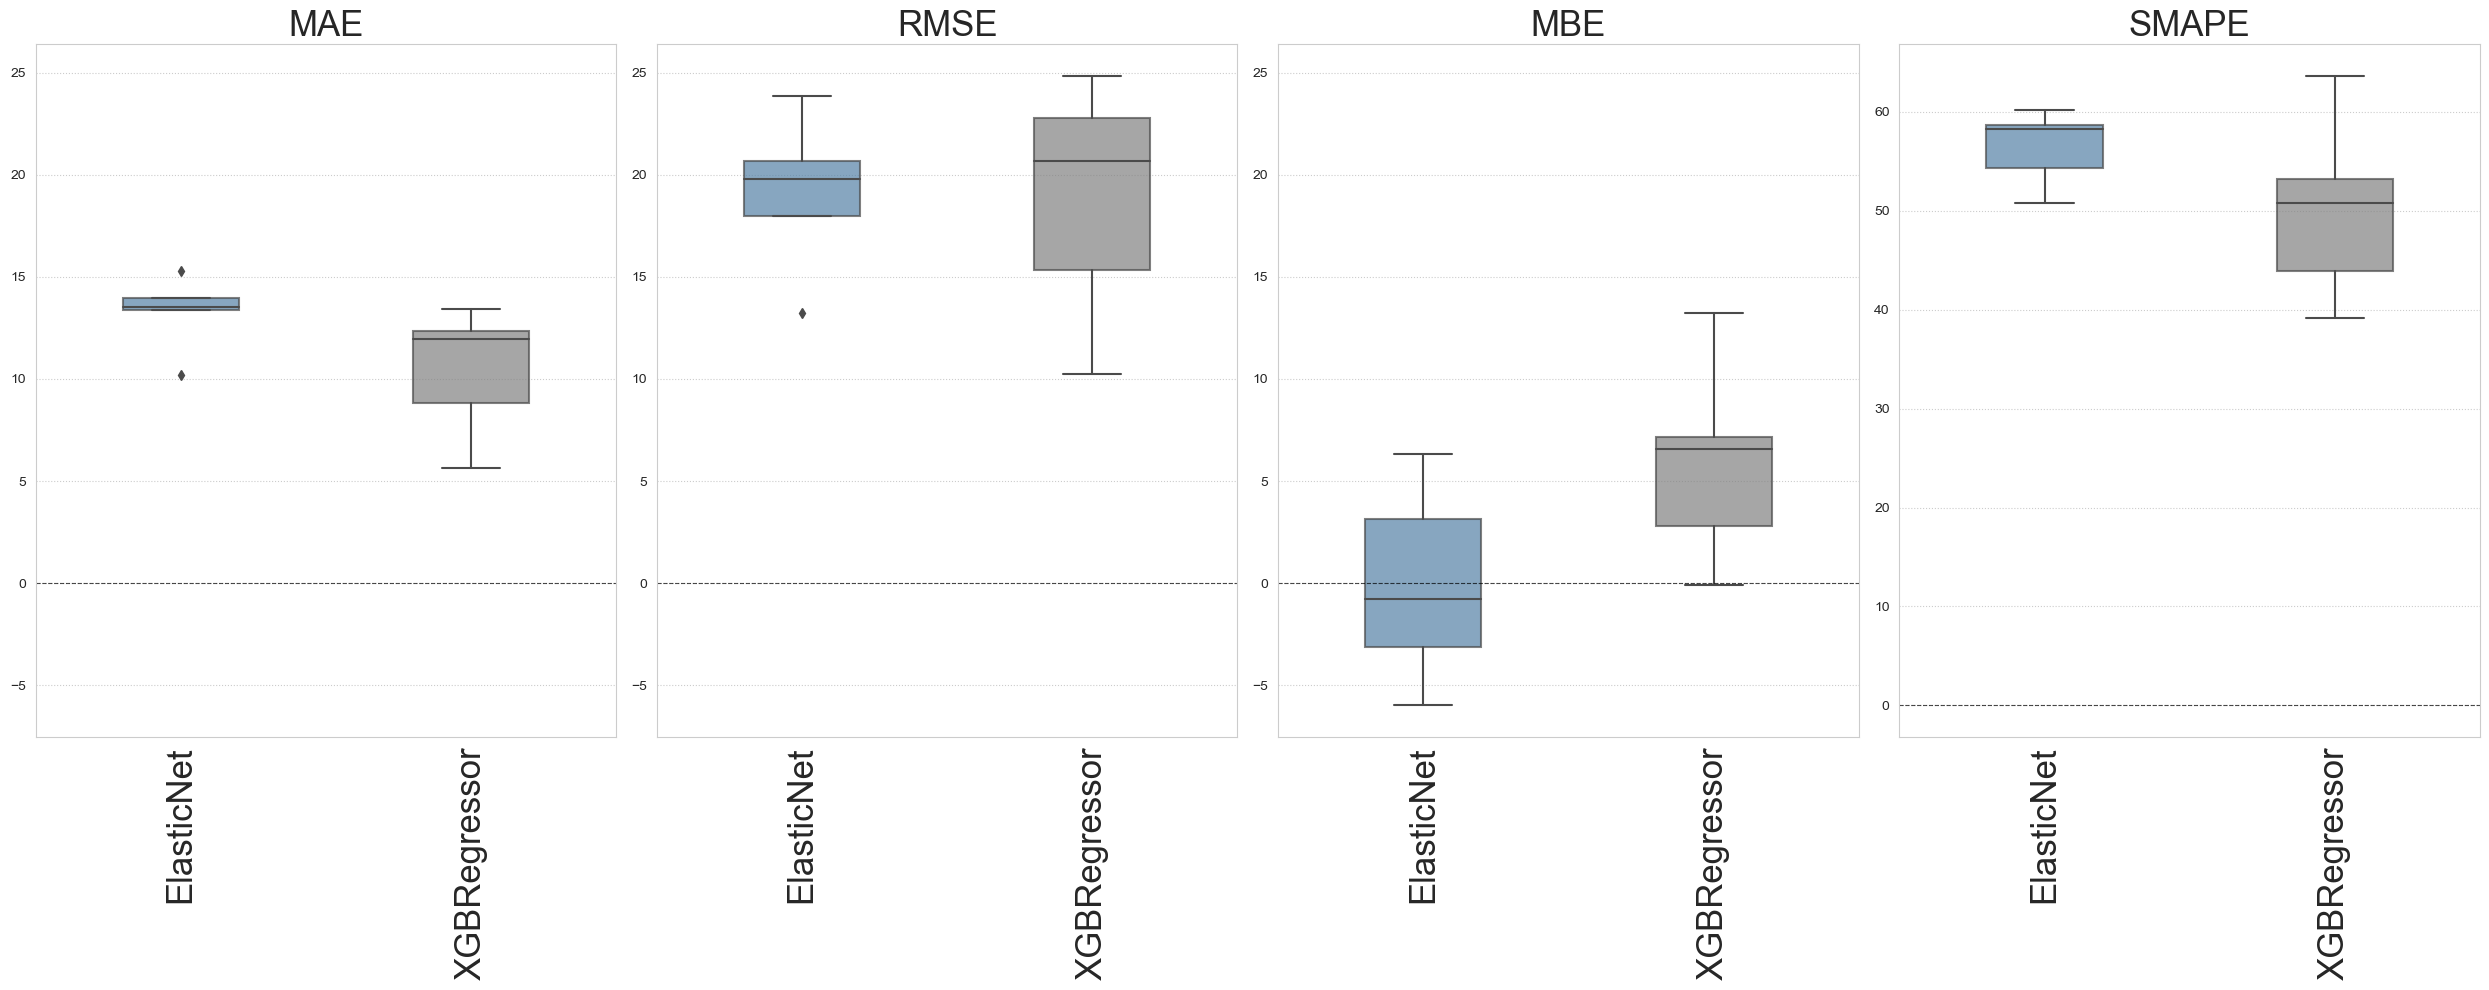

In [37]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Featue selection with ML models for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

# ## Feature selection 
# Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)
# 
# Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
# Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.
# 
# - Logistic Regression (binary rcloss)
# - Elastic Net
# - eXtreme Gradient Boosting
# - Random Forest
# 

import sys, os
from datetime import datetime
import logging
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import re
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings('ignore')

#### Load R packages to process Conditional Random Forest in python
# *NOTE 1: all needed R packages have to be previously loaded in R*
# *NOTE 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*
import rpy2
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr, data

# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

# get libraries for CRF processing, ctree_controls etc
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
tdr = importr("tdr")



targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]


# Get logger  # test: init application
main_logger = f"__feature_extraction_rcloss__"
logger = s.init_logger(main_logger)

## settings for cv
kfolds_and_repeats = 5, 3 # 3, 1  # <k-folds, repeats> for nested cv
inner_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)
# outer_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)
outer_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=1, random_state=seed) # make same as for R nestedcv.train()


## TODO make base outdir ./model_results/degree_of_loss
##  out_dir = os.path.join(base_dir, "path")

## save models and their evaluation in following folders:
Path(f"../../model_results/models_trained/degree_of_loss/nested_cv_models").mkdir(parents=True, exist_ok=True)
Path(f"../../model_results/models_trained/degree_of_loss/final_models").mkdir(parents=True, exist_ok=True)
Path(f"../../model_results/models_evaluation/degree_of_loss").mkdir(parents=True, exist_ok=True)
Path(f"../../model_results/selected_features/degree_of_loss").mkdir(parents=True, exist_ok=True)


# df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb_cantho.xlsx")
df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
#df_candidates = pd.read_excel("../../input_survey_data/input_data_businessreduction_tueb.xlsx")


df_candidates.drop("geometry.1", axis=1, inplace=True)


if target == "Target_relative_contentloss_euro":
    df_candidates[target] = df_candidates[target] * 100  # make target range more comparable with Bred, TODO move to data_clenaing.ipynb

with contextlib.suppress(Exception):
    if target == "Target_relative_contentloss_euro":
        df_candidates.drop("hh_monthly_income_euro", axis=1, inplace=True) 
        df_candidates.drop("shp_registered_capital_euro", axis=1, inplace=True) # drop due to high collinearit with income and sale, and highest number of missing values

with contextlib.suppress(Exception):
    if target == "Target_businessreduction":
        df_candidates.drop("hh_monthly_income_euro", axis=1, inplace=True) 
        df_candidates.drop("shp_content_value_euro", axis=1, inplace=True) 

logger.info(df_candidates.shape)

## Evaluation metrics 
score_metrics = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(em.root_mean_squared_error, greater_is_better=False),
    "MBE": make_scorer(em.mean_bias_error, greater_is_better=False),
    # "R2": "r2",
    "SMAPE": make_scorer(em.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}



## empty variables to store model outputs
eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 
# pipelines = ["pipe_en", "pipe_crf", "pipe_xgb"]  
pipelines = ["pipe_en", "pipe_xgb"]  

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    TIME0 = datetime.now()

    ## load model pipelines
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
 
    try:
        model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # get model name for python models  
    except AttributeError:
        model_name = pipe # get R model name
    
    ## load respective hyperparameter space
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging fro model training is used , rename hyperparmeters
    if "bag" in pipe_name.split("_"):
        logger.info(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}


    logger.info( f"\n############ Applying {model_name} on {target} ############\n ")

    # save original df for later
    df_Xy = df_candidates

    # rm geometry column which only needed for visualization
    df_Xy = df_Xy.drop("geometry", axis=1)

    # get predictor names
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

    ## remove zero-loss records only for rcloss
    if target == "Target_relative_contentloss_euro":
        logger.info(f"Removing {df_Xy.loc[df_Xy[target]==0.0,:].shape[0]} zero loss records")
        df_Xy = df_Xy.loc[df_Xy[target]!=0.0,:]


    ## drop samples where target is nan
    logger.info(f"Removing {df_Xy[target].isna().sum()} records from entire dataset due that these values are nan in target variable")
    df_Xy = df_Xy[ ~df_Xy[target].isna()]

    ## Elastic Net and Random Forest: drop samples where any value is nan
    if (model_name == "ElasticNet") | (model_name == "cforest"):
        print("Dropping records with missing values")
        df_Xy.dropna(inplace=True)
        #df_Xy = df_Xy.apply(lambda x: x.fillna(x.median()), axis=0)
        # print("Impute records with missing values for Elastic Net or cforest",
        #        f"keeping {df_Xy.shape} damage cases for model training and evaluation")


    logger.info(
        f"Finally use {df_Xy.shape[0]} records for feature extraction, from those are {(df_Xy[target][df_Xy[target] == 0.0]).count()} cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]

 
    ## run sklearn model
    if model_name != "cforest":

        print("value ranges of features:", df_Xy.describe())

        ## fit model for unbiased model evaluation and for final model used for Feature importance, Partial Dependence etc.
        mf = t.ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score=score_metrics["MAE"], # tune by getting reducing MAE
            cv=inner_cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=seed,
        )
        models_trained_ncv = mf.model_fit_ncv()

        # save models from nested cv and final model on entire ds
        joblib.dump(models_trained_ncv, f"../../model_results/models_trained/degree_of_loss/nested_cv_models/{model_name}_{target}.joblib")
            
        ## evaluate model    
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,
            cv=outer_cv,
            kfolds=kfolds_and_repeats[0],
            seed=seed,
        )
        model_evaluation_results = me.model_evaluate_ncv()

        
        ## visual check if hyperparameter ranges are good or need to be adapted
        logger.info(f"Performance of best estimators on outer test-sets:") 
        for i in range(len(model_evaluation_results["estimator"])):
            print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


        ## store models evaluation 
        models_scores[model_name] =  {
            k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
        } # get evaluation scores, metric names start with "test_<metricname>"
        
        ## reverse sklearn.cross_validate() outputted regression scores (e.g. MAE, RMSE, SMAPE, R2)
        models_scores[model_name] = me.negate_scores_from_sklearn_cross_valdiate(models_scores[model_name])


        ## Final model

        ## get final model based on best MAE score during outer cv
        best_idx = list(models_scores[model_name]["test_MAE"]).index(min(models_scores[model_name]["test_MAE"]))
        final_model = model_evaluation_results["estimator"][best_idx]
        logger.info(f"Params of best model: {final_model.best_params_}") 
        final_model = final_model.best_estimator_

        logger.info(f"Performance of best model:") 
        for metric in models_scores[model_name].keys():
            print(metric, models_scores[model_name][metric][best_idx])


        ## predict on entire dataset and save final model
        y_pred = final_model.predict(X) ## need to derive regression coefficients 
        final_models_trained[model_name] = final_model 
        joblib.dump(final_model, f"../../model_results/models_trained/degree_of_loss/final_models/{model_name}_{target}.joblib")

        ## Feature importance of best model
        importances = me.permutation_feature_importance(final_model, repeats=5)


        ## regression coefficients for linear models from best estimator
        with contextlib.suppress(Exception):

            models_coef[model_name] = me.calc_regression_coefficients(final_model, y_pred)

            outfile = f"../../model_results/models_evaluation/degree_of_loss/regression_coefficients_{model_name}_{target}.xlsx"
            models_coef[model_name].round(3).to_excel(outfile, index=True)
            logger.info(f"Regression Coefficients:\n {models_coef[model_name].sort_values('probabilities', ascending=False)} \n .. saved to {outfile}")
            
            ## check if any regression coefficient is significant 
            if np.min(models_coef[model_name]["probabilities"]) >= 0.05:
                ## non permanent decorator, extending with creation of log file for warnings
                logger = s.decorate_init_logger(s.init_logger)("__warning_coefs__") 
                logger.info("non of the regression coefficients is significant")
                logger = s.init_logger(main_logger)  # reset to previous state


    ## run R model
    else:
        ## define R model parameters and do nested cross-validation directly in ModelFitting() only for R models
        mf = t.ModelFitting(
            model=pipe,  # pipe contains only name of applied R algorithm 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score=score_metrics["MAE"],
            # tuning_score="neg_mean_absolute_error",
            cv=inner_cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=s.seed
        )
        # NOTE: normalization is not mandatory for decision-trees but might decrease processing time
        models_trained_ncv = mf.r_model_fit_ncv()  # pipe
       
       ## neded to get R estimators 
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,  # make optional in ModelEvlaution() class
            cv=outer_cv,
            kfolds=kfolds_and_repeats[0],
            seed=s.seed
        )
        model_evaluation_results = me.r_model_evaluate_ncv()


        ## get std of CRF from inner folds
        ## TODO use shorter name for r_model_evaluation_dict        
        r_model_evaluation_dict =  {a : [] for a in ["test_MAE", "test_RMSE", "test_MBE", "test_SMAPE"]}
        for idx in range(1, kfolds_and_repeats[0]+1):  # number of estimators , R counts starting from 1
            df = me.r_models_cv_predictions(idx)  # get all crf estimators from outer cv
            r_model_evaluation_dict['test_MAE'].append(mean_absolute_error(df.testy, df.predy))
            r_model_evaluation_dict['test_RMSE'].append(em.root_mean_squared_error(df.testy,df.predy)) #(df.testy, df.predy)
            r_model_evaluation_dict['test_MBE'].append(em.mean_bias_error(df.testy, df.predy))
            # r_model_evaluation_dict['test_R2'].append(em.r2_score(df.testy, df.predy))
            r_model_evaluation_dict['test_SMAPE'].append(em.symmetric_mean_absolute_percentage_error(df.testy, df.predy))
      
      
        ## Final CRF model
        final_model = mf.r_final_model_fit()
        best_idx = list(r_model_evaluation_dict["test_MAE"]).index(min(r_model_evaluation_dict["test_MAE"]))

        ## performance of final CRF model 
        logger.info(f"Performance of best CRF model: ")
        for metric in r_model_evaluation_dict.keys():
            print(f"{metric}: {r_model_evaluation_dict[metric][best_idx]}")
        
        ## Feature importance of best R model
        importances = me.r_permutation_feature_importance(final_model)

        ## store R model evaluation and final R model
        models_scores[model_name] = r_model_evaluation_dict ## store performance scores from R estimators        
        final_models_trained[model_name] = final_model



    # ## Summarize all models and their evaluation

    ## store fitted models and their evaluation results for later 
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv
    predicted_values[model_name] = me.residuals

    ## store Feature Importances of each model
    logger.info("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # averaged importnace scores across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")
    df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    logger.info(f"5 most important features: {df_feature_importances.iloc[:5].index.to_list()}")


    logger.info(
    f"\nTraining and evaluation of {model_name} took {(datetime.now() - TIME0).total_seconds() / 60} minutes\n"
    )
            


## Plot performance ranges of all evaluated estimators from outer cross-validation 
logger.info("Creating boxplots for range of performane scores from outer folds of nested cross-validation")
f.boxplot_outer_scores_ncv(
    models_scores,
    outfile=f"../../model_results/models_evaluation/degree_of_loss/boxplot_scores4ncv_{target}.png")

# store avergaed scores and std for later usage
## TODO remove overhead  -> store avergaed scores and std during loop
xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
xgb_model_evaluation_std = pd.DataFrame(models_scores["XGBRegressor"]).std(axis=0)   # get respective standard deviations
crf__model_evaluation = pd.DataFrame(models_scores["cforest"]).mean(axis=0)
crf_model_evaluation_std = pd.DataFrame(models_scores["cforest"]).std(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).mean(axis=0)
en_model_evaluation_std = pd.DataFrame(models_scores["ElasticNet"]).std(axis=0)
# xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).median(axis=0)  # get median of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
# xgb_model_evaluation_std = pd.DataFrame(models_scores["XGBRegressor"]).std(axis=0)   # get respective standard deviations
# crf__model_evaluation = pd.DataFrame(models_scores["cforest"]).median(axis=0)
# crf_model_evaluation_std = pd.DataFrame(models_scores["cforest"]).std(axis=0)
# en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).median(axis=0)
# en_model_evaluation_std = pd.DataFrame(models_scores["ElasticNet"]).std(axis=0)

model_evaluation = pd.concat([en_model_evaluation, en_model_evaluation_std, xgb_model_evaluation, xgb_model_evaluation_std, crf__model_evaluation, crf_model_evaluation_std], axis=1)
model_evaluation.columns = ["ElasticNet_score", "ElasticNet_score_std", "XGBRegressor_score", "XGBRegressor_score_std", "cforest_score", "cforest_score_std"]

## rename metrics
model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"../../model_results/models_evaluation/degree_of_loss/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
# logger.info(f"Outer evaluation scores of nested cross-validation (mean) :\n {model_evaluation.round(3)} \n.. saved to {outfile}")
logger.info(f"Outer evaluation scores of nested cross-validation (median) :\n {model_evaluation.round(3)} \n.. saved to {outfile}")




## Feature Importances 

#### prepare Feature Importances 
## Have the same feature importance method across all applied ML models
## Weight Importances by model performance on outer loop (mean MAE)
## **Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)**

## weight FI scores based on performance ; weigth importances from better performed models stronger
model_weights =  {
    "XGBRegressor_importances" : np.mean(models_scores["XGBRegressor"]["test_MAE"]),
    "ElasticNet_importances" : np.mean(models_scores["ElasticNet"]["test_MAE"]),
    "cforest_importances" : np.mean(models_scores["cforest"]["test_MAE"]),
}
df_feature_importances_w = fs.calc_weighted_sum_feature_importances(df_feature_importances, model_weights)


####  Plot Feature importances

## the best model has the highest weighted feature importance value
df_feature_importances_plot = df_feature_importances_w

## drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot.weighted_sum_importances > 0.0, : ] 

## plot stacked FI
f.plot_stacked_feature_importances(
    df_feature_importances_plot[["cforest_importances_weighted", "ElasticNet_importances_weighted", "XGBRegressor_importances_weighted",]],
    target_name=target,
    model_names_plot = ("Conditional Random Forest", "Elastic Net", "XGBRegressor"),
    outfile=f"../../model_results/models_evaluation/degree_of_loss/feature_importances_{target}.png"
)


## Save final feature space 
### The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
logger.info(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
logger.info(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_w["weighted_sum_importances"].sort_values(ascending=False).index##[:10]

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates.drop(target, axis=1), # TODO adpat function that target is only once added
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../model_results/selected_features/degree_of_loss/final_predictors_{target}.xlsx"
)



## Partial dependence

## PDP shows the marginal effect that one or two features have on the predicted outcome.

## store partial dependences for each model
pdp_features = {a : {} for a in ["ElasticNet", "XGBRegressor", "cforest"]}

for model_name in ["cforest", "ElasticNet", "XGBRegressor"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]

    ## NOTE scaling mandatory for cforest model (which dont accepts the rescaled values for R PDPs function)
    ## also to have all models in the same plot scaling of the predictors is needed.
    # For EN and cforest incomplete cases are removed, therefore the fitting has to be done on the entire dataset (as used for XGB)
    scaler = MinMaxScaler()
    scaler.fit(df_candidates.drop([target, "geometry"], axis=1))  # needed due that Elastic Net has no incomplete records but needs same nomrlaization as XGB
    X_pdp = pd.DataFrame(
        scaler.transform(X_pdp), # for same x-axis scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            # "percentiles" : (0.05, .95), # causes NAN for some variables for XGB if (0, 1)
            "scale"  : True
        }  
        # get Partial dependences for sklearn models      
        if model_name != "cforest": 
            partial_dep = me.get_partial_dependence(**features_info)
        # get Partial dependences for R models      
        else:  
            #  change function only temporary to process R model instead of sklearn models
            # features_info.pop("percentiles")
            partial_dep = me.decorator_func(**features_info) (me.get_partial_dependence)()  

        pdp_features[model_name][predictor_name] = partial_dep



## Plot PDP

most_important_features = df_feature_importances_plot.sort_values("weighted_sum_importances", ascending=False).index
categorical = [] # ["flowvelocity", "further_variables .."]
ncols = 3
nrows = len(most_important_features[:9])
idx = 0

plt.figure(figsize=(10,25))
# plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)

## create PDP for all three models
for feature in most_important_features[:9]:
    for model_name, color, idx_col in zip(["cforest", "ElasticNet", "XGBRegressor"], ["darkblue", "steelblue","grey"], [0, 0, 0]):

        # idx position of subplot and plot settings
        sns.set_style("whitegrid", {'grid.linestyle': ':'})
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        ## partial dependence of one feature for one model to plot
        df_pd_feature = pdp_features[model_name][feature]  
        
        # plot
        p = f.plot_partial_dependence(
            df_pd_feature, 
            feature_name=feature, 
            partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../../model_results/models_evaluation/degree_of_loss/pdp_{target}.png",
            **feature_info
            )
        p
        #targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
        #if target == "Target_relative_contentloss_euro":
        plt.ylim(0,30)

        visible_ticks = {"top": False, "right": False}
        plt.tick_params(axis="x", which="both", **visible_ticks)
        
    sns.rugplot(df_pd_feature, x=feature, height=.02, color="black")
    idx = idx + 1



### Empirical ~ predicted
## use y_pred cross-valdiated from outer folds, mulitplied by 100 for more readable output
for k,v in predicted_values.items():
    print(f"\n{k} predicted target from cross-valdiated outer folds:")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# ### Plot prediction error 
f.plot_residuals(
    residuals=predicted_values, 
    model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
    model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
    outfile=f"../../model_results/models_evaluation/degree_of_loss/residuals_{target}.png"
)



## investigate why some unexpected predictors are seems to be important
check if coefficient of variantion eg. for sale/production volume


In [16]:
# cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 

# #calculate CV for each column in data frame
# print(df_Xy.apply(cv).sort_values())


# # calc cv for predicted loss
# print("y_pred_xgb", cv(y_pred))


flowvelocity                         36.146101
resilience                           37.703271
contaminations                       39.808591
emergency_measures                   55.508473
shp_employees                        55.870367
flood_experience                     58.809784
bage                                 61.180476
water_depth_cm                       72.948931
b_area                               77.019381
precautionary_measures_lowcost       79.028495
shp_avgmonthly_sale_euro             85.746899
precautionary_measures_expensive    140.309673
Target_relative_contentloss_euro    163.204653
inundation_duration_h               246.193603
dtype: float64
y_pred 20.31882554292679


In [32]:
pdp_features["ElasticNet"]["shp_avgmonthly_sale_euro"] 

,shp_avgmonthly_sale_euro,yhat
0,0.000000,13.611956
1,0.285692,13.611956
2,1.000000,13.611956


In [9]:
import pandas as pd
df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")


In [13]:
# df_candidates.loc[df_candidates.bage < 20, : ].head(20)
df_candidates.shp_avgmonthly_sale_euro.describe()
## hh income 552.4	, sale = 276 or 736.5

count     312.000000
mean      357.942949
std       457.219033
min        92.100000
25%        92.100000
50%       276.200000
75%       276.200000
max      2761.900000
Name: shp_avgmonthly_sale_euro, dtype: float64

In [95]:
def plot_partial_dependence(df_pd_feature, feature_name:str, partial_dependence_name:str, categorical:list, outfile, **kwargs):
    """
    Creates plots for partial dependecies for multiple models
    :param model: Model instance
    :param X_train: 
    :param feature_names: List of features
    :param categorical (list): list of features which are categorical
    :return:
    """
    if feature_name in categorical:
        sns.barplot(
            data=df_pd_feature, 
            x=df_pd_feature[feature_name], 
            y=df_pd_feature[partial_dependence_name], 
            **kwargs
        )
    else:      
        sns.lineplot(
            data=df_pd_feature, 
            x=df_pd_feature[feature_name], 
            y=df_pd_feature[partial_dependence_name], 
            legend=False,
            **kwargs
        )

    #kwargs["ax"].get_xaxis().set_visible(False)
    kwargs["ax"].set_xlabel("")
    kwargs["ax"].set_ylabel("")
    # kwargs["ax"].set_ylabel(feature_name)
    # ax.get_yaxis().set_visible(True)
    kwargs["ax"].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='on',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off'  # labels along the bottom edge are off)
        )
    kwargs["ax"].tick_params(
        axis='y',
        which='both',
        left='on',
        right='off',
    )
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    
  

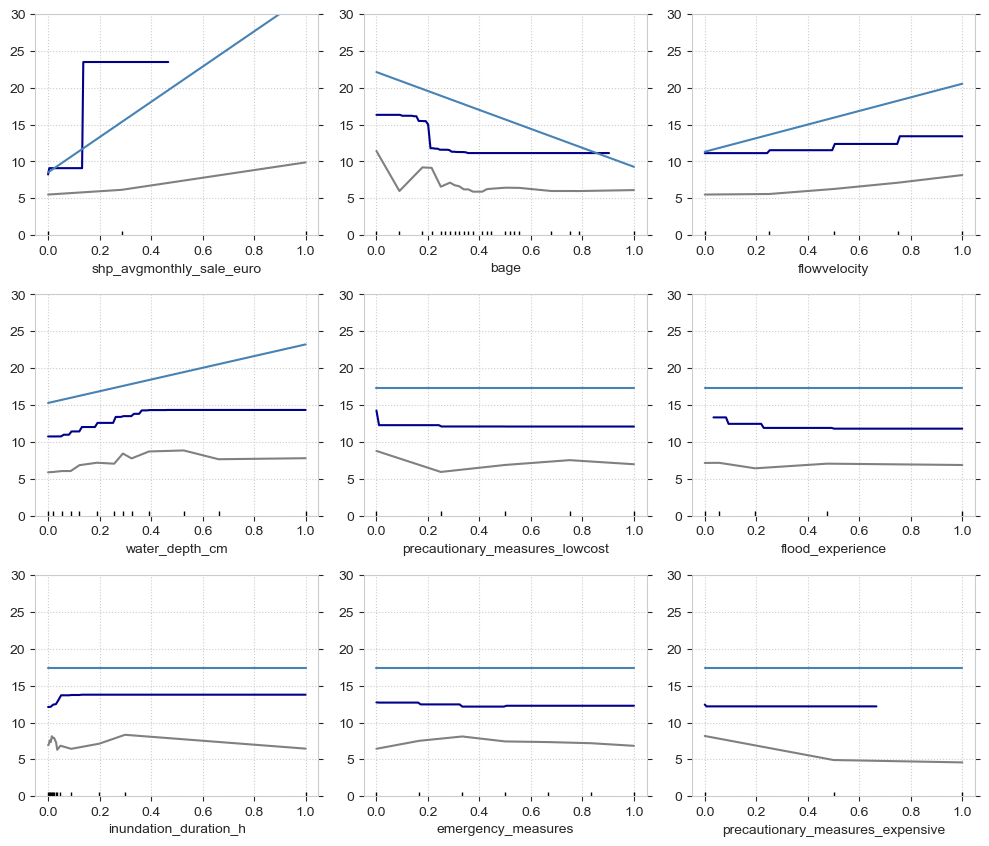

In [96]:

most_important_features = df_feature_importances_plot.sort_values("weighted_sum_importances", ascending=False).index
categorical = [] # ["flowvelocity", "further_variables .."]
ncols = 3
nrows = len(most_important_features[:9])
idx = 0

plt.figure(figsize=(10,25))
# plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)

## create PDP for all three models
for feature in most_important_features[:9]:
    for model_name, color, idx_col in zip(["cforest", "ElasticNet", "XGBRegressor"], ["darkblue", "steelblue","grey"], [0, 0, 0]):

        # idx position of subplot and plot settings
        sns.set_style("whitegrid", {'grid.linestyle': ':'})
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        ## partial dependence of one feature for one model to plot
        df_pd_feature = pdp_features[model_name][feature]  
        
        # plot
        p = plot_partial_dependence(
            df_pd_feature, 
            feature_name=feature, 
            partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../../model_results/models_evaluation/degree_of_loss/pdp_{target}.png",
            **feature_info
            )
        p
        #targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
        #if target == "Target_relative_contentloss_euro":
        plt.ylim(0,30)

        visible_ticks = {"top": False, "right": False}
        plt.tick_params(axis="x", which="both", **visible_ticks)
        
    sns.rugplot(df_pd_feature, x=feature, height=.02, color="black")
    idx = idx + 1



In [74]:
pd.Series(y_pred).describe()

count    123.000000
mean      11.610280
std        2.318375
min        4.770598
25%       10.076472
50%       11.332291
75%       13.278169
max       20.695074
dtype: float64

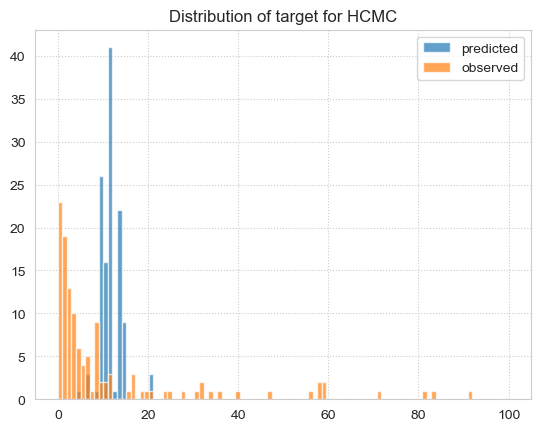

In [75]:
bins = np.linspace(0, 100, 100)

plt.hist(y_pred, bins, alpha=0.7, label='predicted')
plt.hist(y, bins, alpha=0.7, label='observed')
plt.legend(loc='upper right')
plt.title("Distribution of target for HCMC")
plt.show()

In [76]:
# f.boxplot_outer_scores_ncv(
#     models_scores,
#     outfile=f"../../model_results/models_evaluation/degree_of_loss/boxplot_scores4ncv_{target}.png")
models_scores["XGBRegressor"]["test_SMAPE"]

[47.72332913624974,
 55.255031808011495,
 39.97299147536533,
 38.77412517144062,
 43.89551626720023,
 54.679766827399696,
 46.259294345149335,
 36.903883226437884,
 46.83953972816934,
 35.83905345998645]

In [77]:
y.count()

123

In [78]:
# rcloss
# 12-04-2023 01:53:46 - __feature_extraction_rcloss__ - INFO - Params of best model: {'model__seed': 42, 'model__n_estimators': 10, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
# 8 mtry

# bred
# 12-04-2023 03:36:01 - __feature_extraction_rcloss__ - INFO - Params of best model: {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
# 8 mtry


## Fit model --bred

12-10-2023 10:09:25 - __feature_extraction_bred__ - INFO - (353, 15)
12-10-2023 10:09:25 - __feature_extraction_bred__ - INFO - 
############ Applying ElasticNet on Target_businessreduction ############
 
12-10-2023 10:09:25 - __feature_extraction_bred__ - INFO - Removing 0 records from entire dataset due that these values are nan in target variable
12-10-2023 10:09:25 - __feature_extraction_bred__ - INFO - Finally use 321 records for feature extraction, from those are 133 cases with zero-loss or zero-reduction


Dropping records with missing values
value ranges of features:        Target_businessreduction  inundation_duration_h  water_depth_cm   
count                321.000000             321.000000      321.000000  \
mean                  17.199377              10.357321       33.869159   
std                   23.889409              25.996352       25.994020   
min                    0.000000               0.200000        1.000000   
25%                    0.000000               2.000000       10.000000   
50%                   10.000000               3.000000       30.000000   
75%                   30.000000               6.000000       50.000000   
max                  100.000000             240.000000      150.000000   

       flowvelocity  contaminations  flood_experience        bage      b_area   
count    321.000000      321.000000        321.000000  321.000000  321.000000  \
mean       0.305607        0.981308         82.024922   19.894081   85.107477   
std        0.126366        

12-10-2023 10:11:16 - __feature_extraction_bred__ - INFO - Performance of best estimators on outer test-sets:
12-10-2023 10:11:16 - __feature_extraction_bred__ - INFO - Params of best model: {'model__tol': 0.1, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.5, 'model__alpha': 0.5}
12-10-2023 10:11:16 - __feature_extraction_bred__ - INFO - Performance of best model:


ElasticNet:  {'model__tol': 0.1, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.5, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.1, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.5, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.1, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.5, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 1.0, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.1, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.5, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.1, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.5, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.1, 'model__selection': 'rand

12-10-2023 10:11:17 - __feature_extraction_bred__ - INFO - Regression Coefficients:
                             features  coefficients  standard errors  t values   
1              inundation_duration_h       -0.0000          136.901    -0.000  \
4                     contaminations        0.0000           74.344     0.000   
7                             b_area        0.0000          148.865     0.000   
9     precautionary_measures_lowcost       -0.0000           50.476    -0.000   
12                        resilience        0.0000           61.404     0.000   
13          shp_avgmonthly_sale_euro        0.0000           86.083     0.000   
10  precautionary_measures_expensive       -0.1995           74.610    -0.003   
11                     shp_employees       -0.5680          102.801    -0.006   
6                               bage       -0.8226          105.544    -0.008   
2                     water_depth_cm        0.9212           93.153     0.010   
5                   floo

coefs_intercept = np.append(model_intercept, list(model_coefs)) [13.32319123 -0.          0.92122904  3.16592447  0.          2.39150561
 -0.82259669  0.          3.5270417  -0.         -0.19946901 -0.56798793
  0.          0.        ]
Creating log file ./tst_warning_coeff.log due to warning that regression coefficients are all non significant
Dropping records with missing values


R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 10-fold outer CV, using 1 core

R[write to console]: Fitting single final model

R[write to console]: Duration: 42.24996 mins



Nested cross-validation with caret
Method:  cforest 
No filter
Outer loop:  10-fold cv
Inner loop:  10-fold repeatedcv
321 observations, 13 predictors

         mtry  n.filter
Fold 1      4        13
Fold 2     14        13
Fold 3      6        13
Fold 4      4        13
Fold 5     10        13
Fold 6     16        13
Fold 7     12        13
Fold 8     16        13
Fold 9      8        13
Fold 10     8        13

Final parameters:
  mtry
     9

Result:
    RMSE   Rsquared        MAE   
 21.9801     0.1606    16.1936   


12-10-2023 10:53:32 - __model_training__ - INFO - 
Summary CRF 
 $dimx
[1] 321  13

$folds
        mtry n.filter
Fold 1     4       13
Fold 2    14       13
Fold 3     6       13
Fold 4     4       13
Fold 5    10       13
Fold 6    16       13
Fold 7    12       13
Fold 8    16       13
Fold 9     8       13
Fold 10    8       13

$final_param
  mtry
1    9

$result
    RMSE   Rsquared        MAE   
 21.9801     0.1606    16.1936   


R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 10-fold outer CV, using 1 core

R[write to console]: Fitting single final model

R[write to console]: Duration: 51.23779 mins



Nested cross-validation with caret
Method:  cforest 
No filter
Outer loop:  10-fold cv
Inner loop:  10-fold repeatedcv
321 observations, 13 predictors

         mtry  n.filter
Fold 1      4        13
Fold 2     14        13
Fold 3      6        13
Fold 4      4        13
Fold 5     10        13
Fold 6     16        13
Fold 7     12        13
Fold 8     16        13
Fold 9      8        13
Fold 10     8        13

Final parameters:
  mtry
     9

Result:
    RMSE   Rsquared        MAE   
 21.9801     0.1606    16.1936   


12-10-2023 11:44:47 - __model_training__ - INFO - 
Summary CRF 
 $dimx
[1] 321  13

$folds
        mtry n.filter
Fold 1     4       13
Fold 2    14       13
Fold 3     6       13
Fold 4     4       13
Fold 5    10       13
Fold 6    16       13
Fold 7    12       13
Fold 8    16       13
Fold 9     8       13
Fold 10    8       13

$final_param
  mtry
1    9

$result
    RMSE   Rsquared        MAE   
 21.9801     0.1606    16.1936   


R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

12-10-2023 11:44:49 - __feature_extraction_bred__ - INFO - Performance of best CRF model: 


test_MAE: 13.40547524600371
test_RMSE: 18.422690292544743
test_MBE: -1.0813456618523538
test_SMAPE: 51.80265060524303
  |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%


12-10-2023 11:45:00 - __feature_extraction_bred__ - INFO - 
Select features based on permutation feature importance
12-10-2023 11:45:00 - __feature_extraction_bred__ - INFO - 5 most important features: ['emergency_measures', 'water_depth_cm', 'shp_employees', 'bage', 'flowvelocity']
12-10-2023 11:45:00 - __feature_extraction_bred__ - INFO - 
Training and evaluation of cforest took 93.72787688333332 minutes

12-10-2023 11:45:01 - __feature_extraction_bred__ - INFO - 
############ Applying XGBRegressor on Target_businessreduction ############
 
12-10-2023 11:45:01 - __feature_extraction_bred__ - INFO - Removing 0 records from entire dataset due that these values are nan in target variable
12-10-2023 11:45:01 - __feature_extraction_bred__ - INFO - Finally use 353 records for feature extraction, from those are 147 cases with zero-loss or zero-reduction


value ranges of features:        Target_businessreduction  inundation_duration_h  water_depth_cm   
count                353.000000             346.000000      352.000000  \
mean                  17.807365              10.765029       34.497159   
std                   24.461293              26.755890       26.306218   
min                    0.000000               0.200000        1.000000   
25%                    0.000000               2.000000       15.000000   
50%                   10.000000               3.000000       30.000000   
75%                   30.000000               6.000000       50.000000   
max                  100.000000             240.000000      150.000000   

       flowvelocity  contaminations  flood_experience        bage      b_area   
count    353.000000      353.000000        353.000000  330.000000  351.000000  \
mean       0.302550        0.988669         81.810198   19.818182   84.477208   
std        0.125767        0.391510         53.680459   14.23671

12-11-2023 12:03:03 - __feature_extraction_bred__ - INFO - Performance of best estimators on outer test-sets:
12-11-2023 12:03:03 - __feature_extraction_bred__ - INFO - Params of best model: {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
12-11-2023 12:03:03 - __feature_extraction_bred__ - INFO - Performance of best model:


XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 10, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'mode

12-11-2023 12:03:03 - __feature_extraction_bred__ - INFO - 
Select features based on permutation feature importance
12-11-2023 12:03:03 - __feature_extraction_bred__ - INFO - 5 most important features: ['flowvelocity', 'bage', 'resilience', 'water_depth_cm', 'b_area']
12-11-2023 12:03:03 - __feature_extraction_bred__ - INFO - 
Training and evaluation of XGBRegressor took 18.049142816666667 minutes

12-11-2023 12:03:03 - __feature_extraction_bred__ - INFO - Creating boxplots for range of performane scores from outer folds of nested cross-validation
12-11-2023 12:03:20 - __feature_extraction_bred__ - INFO - Outer evaluation scores of nested cross-validation (median) :
        ElasticNet_score  ElasticNet_score_std  XGBRegressor_score   
MAE              18.072                 1.697              15.182  \
RMSE             23.473                 3.786              22.181   
MBE               0.114                 4.592               2.961   
SMAPE            62.285                 7.249   


ElasticNet predicted target from cross-valdiated outer folds:
           nobs  median       mean   min max  variance
empirical   321    10.0  17.199377  [0, 100]    570.70
predicted   321    17.0  16.735202   [8, 27]      4.22

cforest predicted target from cross-valdiated outer folds:
           nobs  median       mean   min max  variance
empirical   321    10.0  17.199377  [0, 100]    570.70
predicted   321    16.0  16.735202   [4, 40]     52.03

XGBRegressor predicted target from cross-valdiated outer folds:
           nobs  median       mean   min max  variance
empirical   353    10.0  17.807365  [0, 100]    598.35
predicted   353    12.0  14.886686  [-3, 67]    122.41


<Figure size 2000x1000 with 0 Axes>

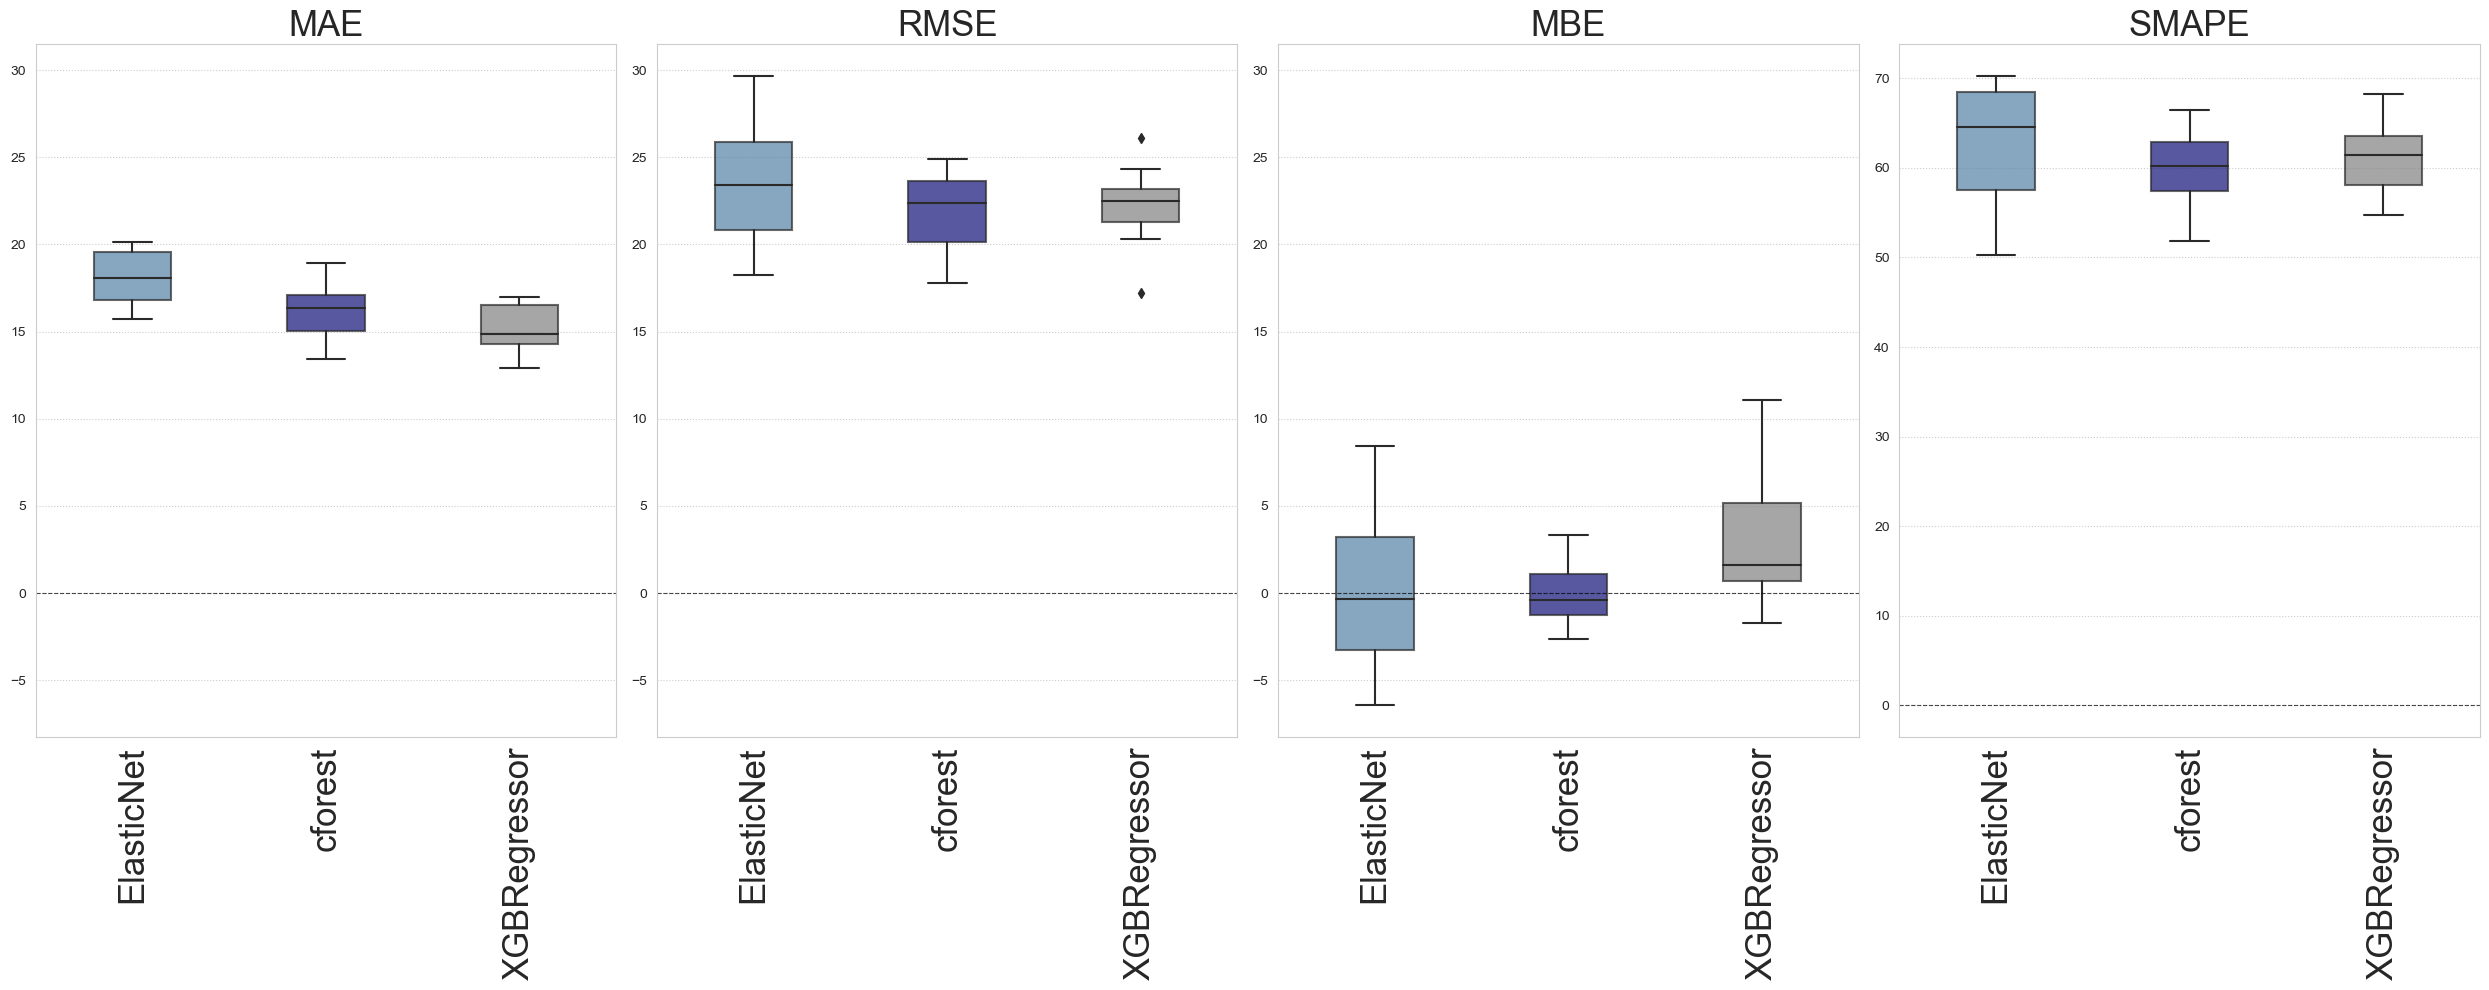

In [79]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Featue selection with ML models for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

# ## Feature selection 
# Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)
# 
# Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
# Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.
# 
# - Logistic Regression (binary rcloss)
# - Elastic Net
# - eXtreme Gradient Boosting
# - Random Forest
# 

import sys, os
from datetime import datetime
import logging
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import re
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings('ignore')

#### Load R packages to process Conditional Random Forest in python
# *NOTE 1: all needed R packages have to be previously loaded in R*
# *NOTE 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*
import rpy2
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr, data

# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

# get libraries for CRF processing, ctree_controls etc
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
tdr = importr("tdr")



targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[1]


# Get logger  # test: init application
main_logger = f"__feature_extraction_bred__"
logger = s.init_logger(main_logger)

## settings for cv
kfolds_and_repeats = 10, 5 # 3, 1  # <k-folds, repeats> for nested cv
inner_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)
# outer_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)
outer_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=1, random_state=seed) # make same as for R nestedcv.train()


## TODO make base outdir ./model_results/degree_of_loss
##  out_dir = os.path.join(base_dir, "path")

## save models and their evaluation in following folders:
Path(f"../../model_results/models_trained/degree_of_loss/nested_cv_models").mkdir(parents=True, exist_ok=True)
Path(f"../../model_results/models_trained/degree_of_loss/final_models").mkdir(parents=True, exist_ok=True)
Path(f"../../model_results/models_evaluation/degree_of_loss").mkdir(parents=True, exist_ok=True)
Path(f"../../model_results/selected_features/degree_of_loss").mkdir(parents=True, exist_ok=True)


# df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb_cantho.xlsx")
# df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
df_candidates = pd.read_excel("../../input_survey_data/input_data_businessreduction_tueb.xlsx")

df_candidates.drop("geometry.1", axis=1, inplace=True)

if target == "Target_relative_contentloss_euro":
    df_candidates[target] = df_candidates[target] * 100  # make target range more comparable with Bred, TODO move to data_clenaing.ipynb

with contextlib.suppress(Exception):
    if target == "Target_relative_contentloss_euro":
        df_candidates.drop("hh_monthly_income_euro", axis=1, inplace=True) 
        df_candidates.drop("shp_registered_capital_euro", axis=1, inplace=True) # drop due to high collinearit with income and sale, and highest number of missing values

with contextlib.suppress(Exception):
    if target == "Target_businessreduction":
        df_candidates.drop("hh_monthly_income_euro", axis=1, inplace=True) 
        df_candidates.drop("shp_content_value_euro", axis=1, inplace=True) 

logger.info(df_candidates.shape)

## Evaluation metrics 
score_metrics = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(em.root_mean_squared_error, greater_is_better=False),
    "MBE": make_scorer(em.mean_bias_error, greater_is_better=False),
    # "R2": "r2",
    "SMAPE": make_scorer(em.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}



## empty variables to store model outputs
eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 
pipelines = ["pipe_en", "pipe_crf", "pipe_xgb"]  
# pipelines = ["pipe_crf"]  

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    TIME0 = datetime.now()

    ## load model pipelines
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
 
    try:
        model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # get model name for python models  
    except AttributeError:
        model_name = pipe # get R model name
    
    ## load respective hyperparameter space
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging fro model training is used , rename hyperparmeters
    if "bag" in pipe_name.split("_"):
        logger.info(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}


    logger.info( f"\n############ Applying {model_name} on {target} ############\n ")

    # save original df for later
    df_Xy = df_candidates

    # rm geometry column which only needed for visualization
    df_Xy = df_Xy.drop("geometry", axis=1)

    # get predictor names
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

    ## remove zero-loss records only for combined dataset
    if target == "Target_relative_contentloss_euro":
        logger.info(f"Removing {df_Xy.loc[df_Xy[target]==0.0,:].shape[0]} zero loss records")
        df_Xy = df_Xy.loc[df_Xy[target]!=0.0,:]


    ## drop samples where target is nan
    logger.info(f"Removing {df_Xy[target].isna().sum()} records from entire dataset due that these values are nan in target variable")
    df_Xy = df_Xy[ ~df_Xy[target].isna()]

    ## Elastic Net and Random Forest: drop samples where any value is nan
    if (model_name == "ElasticNet") | (model_name == "cforest"):
        print("Dropping records with missing values")
        df_Xy.dropna(inplace=True)
        #df_Xy = df_Xy.apply(lambda x: x.fillna(x.median()), axis=0)
        # print("Impute records with missing values for Elastic Net or cforest",
        #        f"keeping {df_Xy.shape} damage cases for model training and evaluation")


    logger.info(
        f"Finally use {df_Xy.shape[0]} records for feature extraction, from those are {(df_Xy[target][df_Xy[target] == 0.0]).count()} cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]

 
    ## run sklearn model
    if model_name != "cforest":

        print("value ranges of features:", df_Xy.describe())

        ## fit model for unbiased model evaluation and for final model used for Feature importance, Partial Dependence etc.
        mf = t.ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score=score_metrics["MAE"], # tune by getting reducing MAE
            cv=inner_cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=seed,
        )
        models_trained_ncv = mf.model_fit_ncv()

        # save models from nested cv and final model on entire ds
        joblib.dump(models_trained_ncv, f"../../model_results/models_trained/degree_of_loss/nested_cv_models/{model_name}_{target}.joblib")
            
        ## evaluate model    
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,
            cv=outer_cv,
            kfolds=kfolds_and_repeats[0],
            seed=seed,
        )
        model_evaluation_results = me.model_evaluate_ncv()

        
        ## visual check if hyperparameter ranges are good or need to be adapted
        logger.info(f"Performance of best estimators on outer test-sets:") 
        for i in range(len(model_evaluation_results["estimator"])):
            print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


        ## store models evaluation 
        models_scores[model_name] =  {
            k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
        } # get evaluation scores, metric names start with "test_<metricname>"
        
        ## reverse sklearn.cross_validate() outputted regression scores (e.g. MAE, RMSE, SMAPE, R2)
        models_scores[model_name] = me.negate_scores_from_sklearn_cross_valdiate(models_scores[model_name])


        ## Final model

        ## get final model based on best MAE score during outer cv
        best_idx = list(models_scores[model_name]["test_MAE"]).index(min(models_scores[model_name]["test_MAE"]))
        final_model = model_evaluation_results["estimator"][best_idx]
        logger.info(f"Params of best model: {final_model.best_params_}") 
        final_model = final_model.best_estimator_

        logger.info(f"Performance of best model:") 
        for metric in models_scores[model_name].keys():
            print(metric, models_scores[model_name][metric][best_idx])


        ## predict on entire dataset and save final model
        y_pred = final_model.predict(X) ## need to derive regression coefficients 
        final_models_trained[model_name] = final_model 
        joblib.dump(final_model, f"../../model_results/models_trained/degree_of_loss/final_models/{model_name}_{target}.joblib")

        ## Feature importance of best model
        importances = me.permutation_feature_importance(final_model, repeats=5)


        ## regression coefficients for linear models from best estimator
        with contextlib.suppress(Exception):

            models_coef[model_name] = me.calc_regression_coefficients(final_model, y_pred)

            outfile = f"../../model_results/models_evaluation/degree_of_loss/regression_coefficients_{model_name}_{target}.xlsx"
            models_coef[model_name].round(3).to_excel(outfile, index=True)
            logger.info(f"Regression Coefficients:\n {models_coef[model_name].sort_values('probabilities', ascending=False)} \n .. saved to {outfile}")
            
            ## check if any regression coefficient is significant 
            if np.min(models_coef[model_name]["probabilities"]) >= 0.05:
                ## non permanent decorator, extending with creation of log file for warnings
                logger = s.decorate_init_logger(s.init_logger)("__warning_coefs__") 
                logger.info("non of the regression coefficients is significant")
                logger = s.init_logger(main_logger)  # reset to previous state


    ## run R model
    else:
         ## define model settings
        mf = t.ModelFitting(
            model=pipe,  # pipe contains only name of applied R algorithm 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score=score_metrics["MAE"],
            # tuning_score="neg_mean_absolute_error",
            cv=inner_cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=s.seed
        )
        # NOTE: normalization is not mandatory for decision-trees but might decrease processing time
        models_trained_ncv = mf.r_model_fit_ncv()  # pipe
       
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,  # make optional in ModelEvlaution() class
            cv=outer_cv,
            kfolds=kfolds_and_repeats[0],
            seed=s.seed
        )
        model_evaluation_results = me.r_model_evaluate_ncv()


        ## get std of CRF from inner folds
        ## TODO shorter name for r_model_evaluation_dict        
        r_model_evaluation_dict =  {a : [] for a in ["test_MAE", "test_RMSE", "test_MBE", "test_SMAPE"]}
        # r_model_evaluation_dict =  {a : [] for a in ["test_MAE", "test_RMSE", "test_MBE", "test_R2", "test_SMAPE"]}
        for idx in range(1, kfolds_and_repeats[0]+1):  # number of estimators , R counts starting from 1
            df = me.r_models_cv_predictions(idx)  # get all crf estimators from outer cv
            r_model_evaluation_dict['test_MAE'].append(mean_absolute_error(df.testy, df.predy))
            r_model_evaluation_dict['test_RMSE'].append(em.root_mean_squared_error(df.testy,df.predy)) #(df.testy, df.predy)
            r_model_evaluation_dict['test_MBE'].append(em.mean_bias_error(df.testy, df.predy))
            # r_model_evaluation_dict['test_R2'].append(em.r2_score(df.testy, df.predy))
            r_model_evaluation_dict['test_SMAPE'].append(em.symmetric_mean_absolute_percentage_error(df.testy, df.predy))
      
      
        ## Final CRF model
        final_model = mf.r_final_model_fit()
        best_idx = list(r_model_evaluation_dict["test_MAE"]).index(min(r_model_evaluation_dict["test_MAE"]))

        ## performance of final CRF model 
        logger.info(f"Performance of best CRF model: ")
        for metric in r_model_evaluation_dict.keys():
            print(f"{metric}: {r_model_evaluation_dict[metric][best_idx]}")
        
        ## Feature importance of best model
        importances = me.r_permutation_feature_importance(final_model)

        ## store model evaluation and final model
        models_scores[model_name] = r_model_evaluation_dict ## store performance scores from R estimators        
        final_models_trained[model_name] = final_model



    # ## Summarize all models and their evaluation

    ## store fitted models and their evaluation results for later 
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv
    predicted_values[model_name] = me.residuals

    ## store Feature Importances of each model
    logger.info("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # averaged importnace scores across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")
    df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    logger.info(f"5 most important features: {df_feature_importances.iloc[:5].index.to_list()}")


    logger.info(
    f"\nTraining and evaluation of {model_name} took {(datetime.now() - TIME0).total_seconds() / 60} minutes\n"
    )
            


## Plot performance ranges of all evaluated estimators from outer cross-validation 
logger.info("Creating boxplots for range of performane scores from outer folds of nested cross-validation")
f.boxplot_outer_scores_ncv(
    models_scores,
    outfile=f"../../model_results/models_evaluation/degree_of_loss/boxplot_scores4ncv_{target}.png")

# store avergaed scores and std for later usage
## TODO remove overhead  -> store avergaed scores and std during loop
xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
xgb_model_evaluation_std = pd.DataFrame(models_scores["XGBRegressor"]).std(axis=0)   # get respective standard deviations
crf__model_evaluation = pd.DataFrame(models_scores["cforest"]).mean(axis=0)
crf_model_evaluation_std = pd.DataFrame(models_scores["cforest"]).std(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).mean(axis=0)
en_model_evaluation_std = pd.DataFrame(models_scores["ElasticNet"]).std(axis=0)
# xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).median(axis=0)  # get median of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
# xgb_model_evaluation_std = pd.DataFrame(models_scores["XGBRegressor"]).std(axis=0)   # get respective standard deviations
# crf__model_evaluation = pd.DataFrame(models_scores["cforest"]).median(axis=0)
# crf_model_evaluation_std = pd.DataFrame(models_scores["cforest"]).std(axis=0)
# en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).median(axis=0)
# en_model_evaluation_std = pd.DataFrame(models_scores["ElasticNet"]).std(axis=0)

model_evaluation = pd.concat([en_model_evaluation, en_model_evaluation_std, xgb_model_evaluation, xgb_model_evaluation_std, crf__model_evaluation, crf_model_evaluation_std], axis=1)
model_evaluation.columns = ["ElasticNet_score", "ElasticNet_score_std", "XGBRegressor_score", "XGBRegressor_score_std", "cforest_score", "cforest_score_std"]

## rename metrics
model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"../../model_results/models_evaluation/degree_of_loss/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
# logger.info(f"Outer evaluation scores of nested cross-validation (mean) :\n {model_evaluation.round(3)} \n.. saved to {outfile}")
logger.info(f"Outer evaluation scores of nested cross-validation (median) :\n {model_evaluation.round(3)} \n.. saved to {outfile}")




## Feature Importances 

#### prepare Feature Importances 
## Have the same feature importance method across all applied ML models
## Weight Importances by model performance on outer loop (mean MAE)
## **Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)**

## weight FI scores based on performance ; weigth importances from better performed models stronger
model_weights =  {
    "XGBRegressor_importances" : np.mean(models_scores["XGBRegressor"]["test_MAE"]),
    "ElasticNet_importances" : np.mean(models_scores["ElasticNet"]["test_MAE"]),
    "cforest_importances" : np.mean(models_scores["cforest"]["test_MAE"]),
}
df_feature_importances_w = fs.calc_weighted_sum_feature_importances(df_feature_importances, model_weights)


####  Plot Feature importances

## the best model has the highest weighted feature importance value
df_feature_importances_plot = df_feature_importances_w

## drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot.weighted_sum_importances > 0.0, : ] 

## plot stacked FI
f.plot_stacked_feature_importances(
    df_feature_importances_plot[["cforest_importances_weighted", "ElasticNet_importances_weighted", "XGBRegressor_importances_weighted",]],
    target_name=target,
    model_names_plot = ("Conditional Random Forest", "Elastic Net", "XGBRegressor"),
    outfile=f"../../model_results/models_evaluation/degree_of_loss/feature_importances_{target}.png"
)


## Save final feature space 
### The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
logger.info(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
logger.info(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_w["weighted_sum_importances"].sort_values(ascending=False).index##[:10]

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates.drop(target, axis=1), # TODO adpat function that target is only once added
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../model_results/selected_features/degree_of_loss/final_predictors_{target}.xlsx"
)



## Partial dependence

## PDP shows the marginal effect that one or two features have on the predicted outcome.

## store partial dependences for each model
pdp_features = {a : {} for a in ["ElasticNet", "XGBRegressor", "cforest"]}

for model_name in ["cforest", "ElasticNet", "XGBRegressor"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]

    ## NOTE scaling mandatory for cforest model (which dont accepts the rescaled values for R PDPs function)
    ## also to have all models in the same plot scaling of the predictors is needed.
    # For EN and cforest incomplete cases are removed, therefore the fitting has to be done on the entire dataset (as used for XGB)
    scaler = MinMaxScaler()
    scaler.fit(df_candidates.drop([target, "geometry"], axis=1))  # needed due that Elastic Net has no incomplete records but needs same nomrlaization as XGB

    X_pdp = pd.DataFrame(
        scaler.transform(X_pdp), # for same x-axis scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            # "percentiles" : (0.05, .95), # causes NAN for some variables for XGB if (0, 1)
            "scale"  : True
        }  
        # get Partial dependences for sklearn models      
        if model_name != "cforest": 
            partial_dep = me.get_partial_dependence(**features_info)
        # get Partial dependences for R models      
        else:  
            #  change function only temporary to process R model instead of sklearn models
            # features_info.pop("percentiles")
            partial_dep = me.decorator_func(**features_info) (me.get_partial_dependence)()  

        pdp_features[model_name][predictor_name] = partial_dep



## Plot PDP

most_important_features = df_feature_importances_plot.sort_values("weighted_sum_importances", ascending=False).index
categorical = [] # ["flowvelocity", "further_variables .."]
ncols = 3
nrows = len(most_important_features[:10])
idx = 0

plt.figure(figsize=(10,25))
# plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)

## create PDP for all three models
for feature in most_important_features[:9]:
    for model_name, color, idx_col in zip(["cforest", "ElasticNet", "XGBRegressor"], ["darkblue", "steelblue","grey"], [0, 0, 0]):

        # idx position of subplot and plot settings
        sns.set_style("whitegrid", {'grid.linestyle': ':'})
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        ## partial dependence of one feature for one model to plot
        df_pd_feature = pdp_features[model_name][feature]  
        
        # plot
        p = f.plot_partial_dependence(
            df_pd_feature, 
            feature_name=feature, 
            partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../../model_results/models_evaluation/degree_of_loss/pdp_{target}.png",
            **feature_info
            )
        p
        # sns.rugplot(pdp_features[model_name][feature], x=feature,  y="yhat", height=-.05)
        #targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
        #if target == "Target_relative_contentloss_euro":
        plt.ylim(0,30)

        visible_ticks = {"top": False, "right": False}
        plt.tick_params(axis="x", which="both", **visible_ticks)
        
    sns.rugplot(df_pd_feature, x=feature, height=.02, color="black")
    idx = idx + 1



### Empirical ~ predicted
## use y_pred cross-valdiated from outer folds, mulitplied by 100 for more readable output
for k,v in predicted_values.items():
    print(f"\n{k} predicted target from cross-valdiated outer folds:")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# ### Plot prediction error 
f.plot_residuals(
    residuals=predicted_values, 
    model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
    model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
    outfile=f"../../model_results/models_evaluation/degree_of_loss/residuals_{target}.png"
)



In [94]:

## Feature Importances 

#### prepare Feature Importances 
## Have the same feature importance method across all applied ML models
## Weight Importances by model performance on outer loop (mean MAE)
## **Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)**

## weight FI scores based on performance ; weigth importances from better performed models stronger
model_weights =  {
    "XGBRegressor_importances" : np.mean(models_scores["XGBRegressor"]["test_MAE"]),
    "ElasticNet_importances" : np.mean(models_scores["ElasticNet"]["test_MAE"]),
    "cforest_importances" : np.mean(models_scores["cforest"]["test_MAE"]),
}
df_feature_importances_w = fs.calc_weighted_sum_feature_importances(df_feature_importances, model_weights)


####  Plot Feature importances

## the best model has the highest weighted feature importance value
df_feature_importances_plot = df_feature_importances_w

## drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot.weighted_sum_importances > 0.0, : ] 

## plot stacked FI
f.plot_stacked_feature_importances(
    df_feature_importances_plot[["cforest_importances_weighted", "ElasticNet_importances_weighted", "XGBRegressor_importances_weighted",]],
    target_name=target,
    model_names_plot = ("Conditional Random Forest", "Elastic Net", "XGBRegressor"),
    outfile=f"../../model_results/models_evaluation/degree_of_loss/feature_importances_{target}.png"
)


## Save final feature space 
### The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
logger.info(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
logger.info(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_w["weighted_sum_importances"].sort_values(ascending=False).index##[:10]

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates.drop(target, axis=1), # TODO adpat function that target is only once added
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../model_results/selected_features/degree_of_loss/final_predictors_{target}.xlsx"
)



## Partial dependence

## PDP shows the marginal effect that one or two features have on the predicted outcome.

## store partial dependences for each model
pdp_features = {a : {} for a in ["ElasticNet", "XGBRegressor", "cforest"]}

for model_name in ["cforest", "ElasticNet", "XGBRegressor"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]

    ## NOTE scaling mandatory for cforest model (which dont accepts the rescaled values for R PDPs function)
    ## also to have all models in the same plot scaling of the predictors is needed.
    # For EN and cforest incomplete cases are removed, therefore the fitting has to be done on the entire dataset (as used for XGB)
    scaler = MinMaxScaler()
    scaler.fit(df_candidates.drop([target, "geometry"], axis=1))  # needed due that Elastic Net has no incomplete records but needs same nomrlaization as XGB
    X_pdp = pd.DataFrame(
        scaler.transform(X_pdp), # for same x-axis scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            # "percentiles" : (0.05, .95), # causes NAN for some variables for XGB if (0, 1)
            "scale"  : True
        }  
        # get Partial dependences for sklearn models      
        if model_name != "cforest": 
            partial_dep = me.get_partial_dependence(**features_info)
        # get Partial dependences for R models      
        else:  
            #  change function only temporary to process R model instead of sklearn models
            # features_info.pop("percentiles")
            partial_dep = me.decorator_func(**features_info) (me.get_partial_dependence)()  

        pdp_features[model_name][predictor_name] = partial_dep



12-12-2023 12:44:52 - __feature_selection__ - INFO - Normalize columns to scale: 0 - 10
12-12-2023 12:44:57 - __feature_extraction_rcloss__ - INFO - Dropping 0 records from entire dataset due that these values are nan in target variable
12-12-2023 12:44:57 - __feature_extraction_rcloss__ - INFO - Keeping 312 records and 15 features
12-12-2023 12:44:57 - __feature_selection__ - INFO - total features: 14
12-12-2023 12:44:57 - __feature_selection__ - INFO - dropped features: 0
12-12-2023 12:44:57 - __feature_selection__ - INFO - selected 14 features: 
['shp_avgmonthly_sale_euro', 'bage', 'flowvelocity', 'water_depth_cm', 'precautionary_measures_lowcost', 'flood_experience', 'inundation_duration_h', 'emergency_measures', 'precautionary_measures_expensive', 'resilience', 'b_area', 'shp_employees', 'contaminations', 'geometry']

12-12-2023 12:44:57 - __feature_selection__ - INFO - Saving selected features to disk: ../../model_results/selected_features/degree_of_loss/final_predictors_Target_r

<Figure size 3000x2200 with 0 Axes>

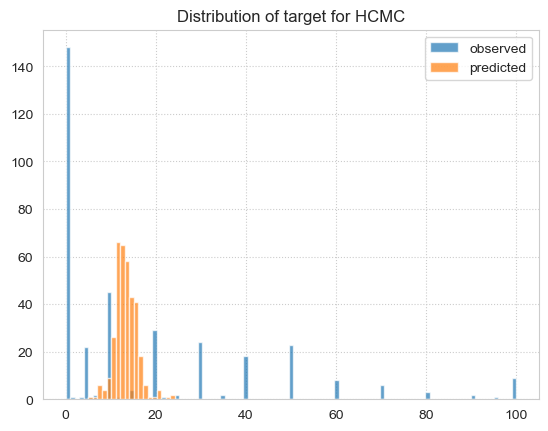

In [80]:
bins = np.linspace(0, 100, 100)

plt.hist(y, bins, alpha=0.7, label='observed')
plt.hist(y_pred, bins, alpha=0.7, label='predicted')
plt.legend(loc='upper right')
plt.title("Distribution of target for HCMC")
plt.show()

In [42]:
#         # "model__lambda": [ 0.0, 0.5, 1.0],
#         # "model__alpha": [ 0.0, 0.5, 1.0],
#         # "model__min_child_weight": [ 4, 5, 6],

r_model_evaluation_results

{'test_MAE': 16.19359584037606,
 'test_RMSE': 21.980088837122548,
 'test_MBE': -0.0432150470646689,
 'test_R2': 0.1508134247861841,
 'test_SMAPE': 59.95199473008353}

Index(['inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'contaminations', 'flood_experience', 'bage', 'b_area',
       'emergency_measures', 'precautionary_measures_lowcost',
       'precautionary_measures_expensive', 'shp_employees', 'resilience',
       'shp_avgmonthly_sale_euro'],
      dtype='object')


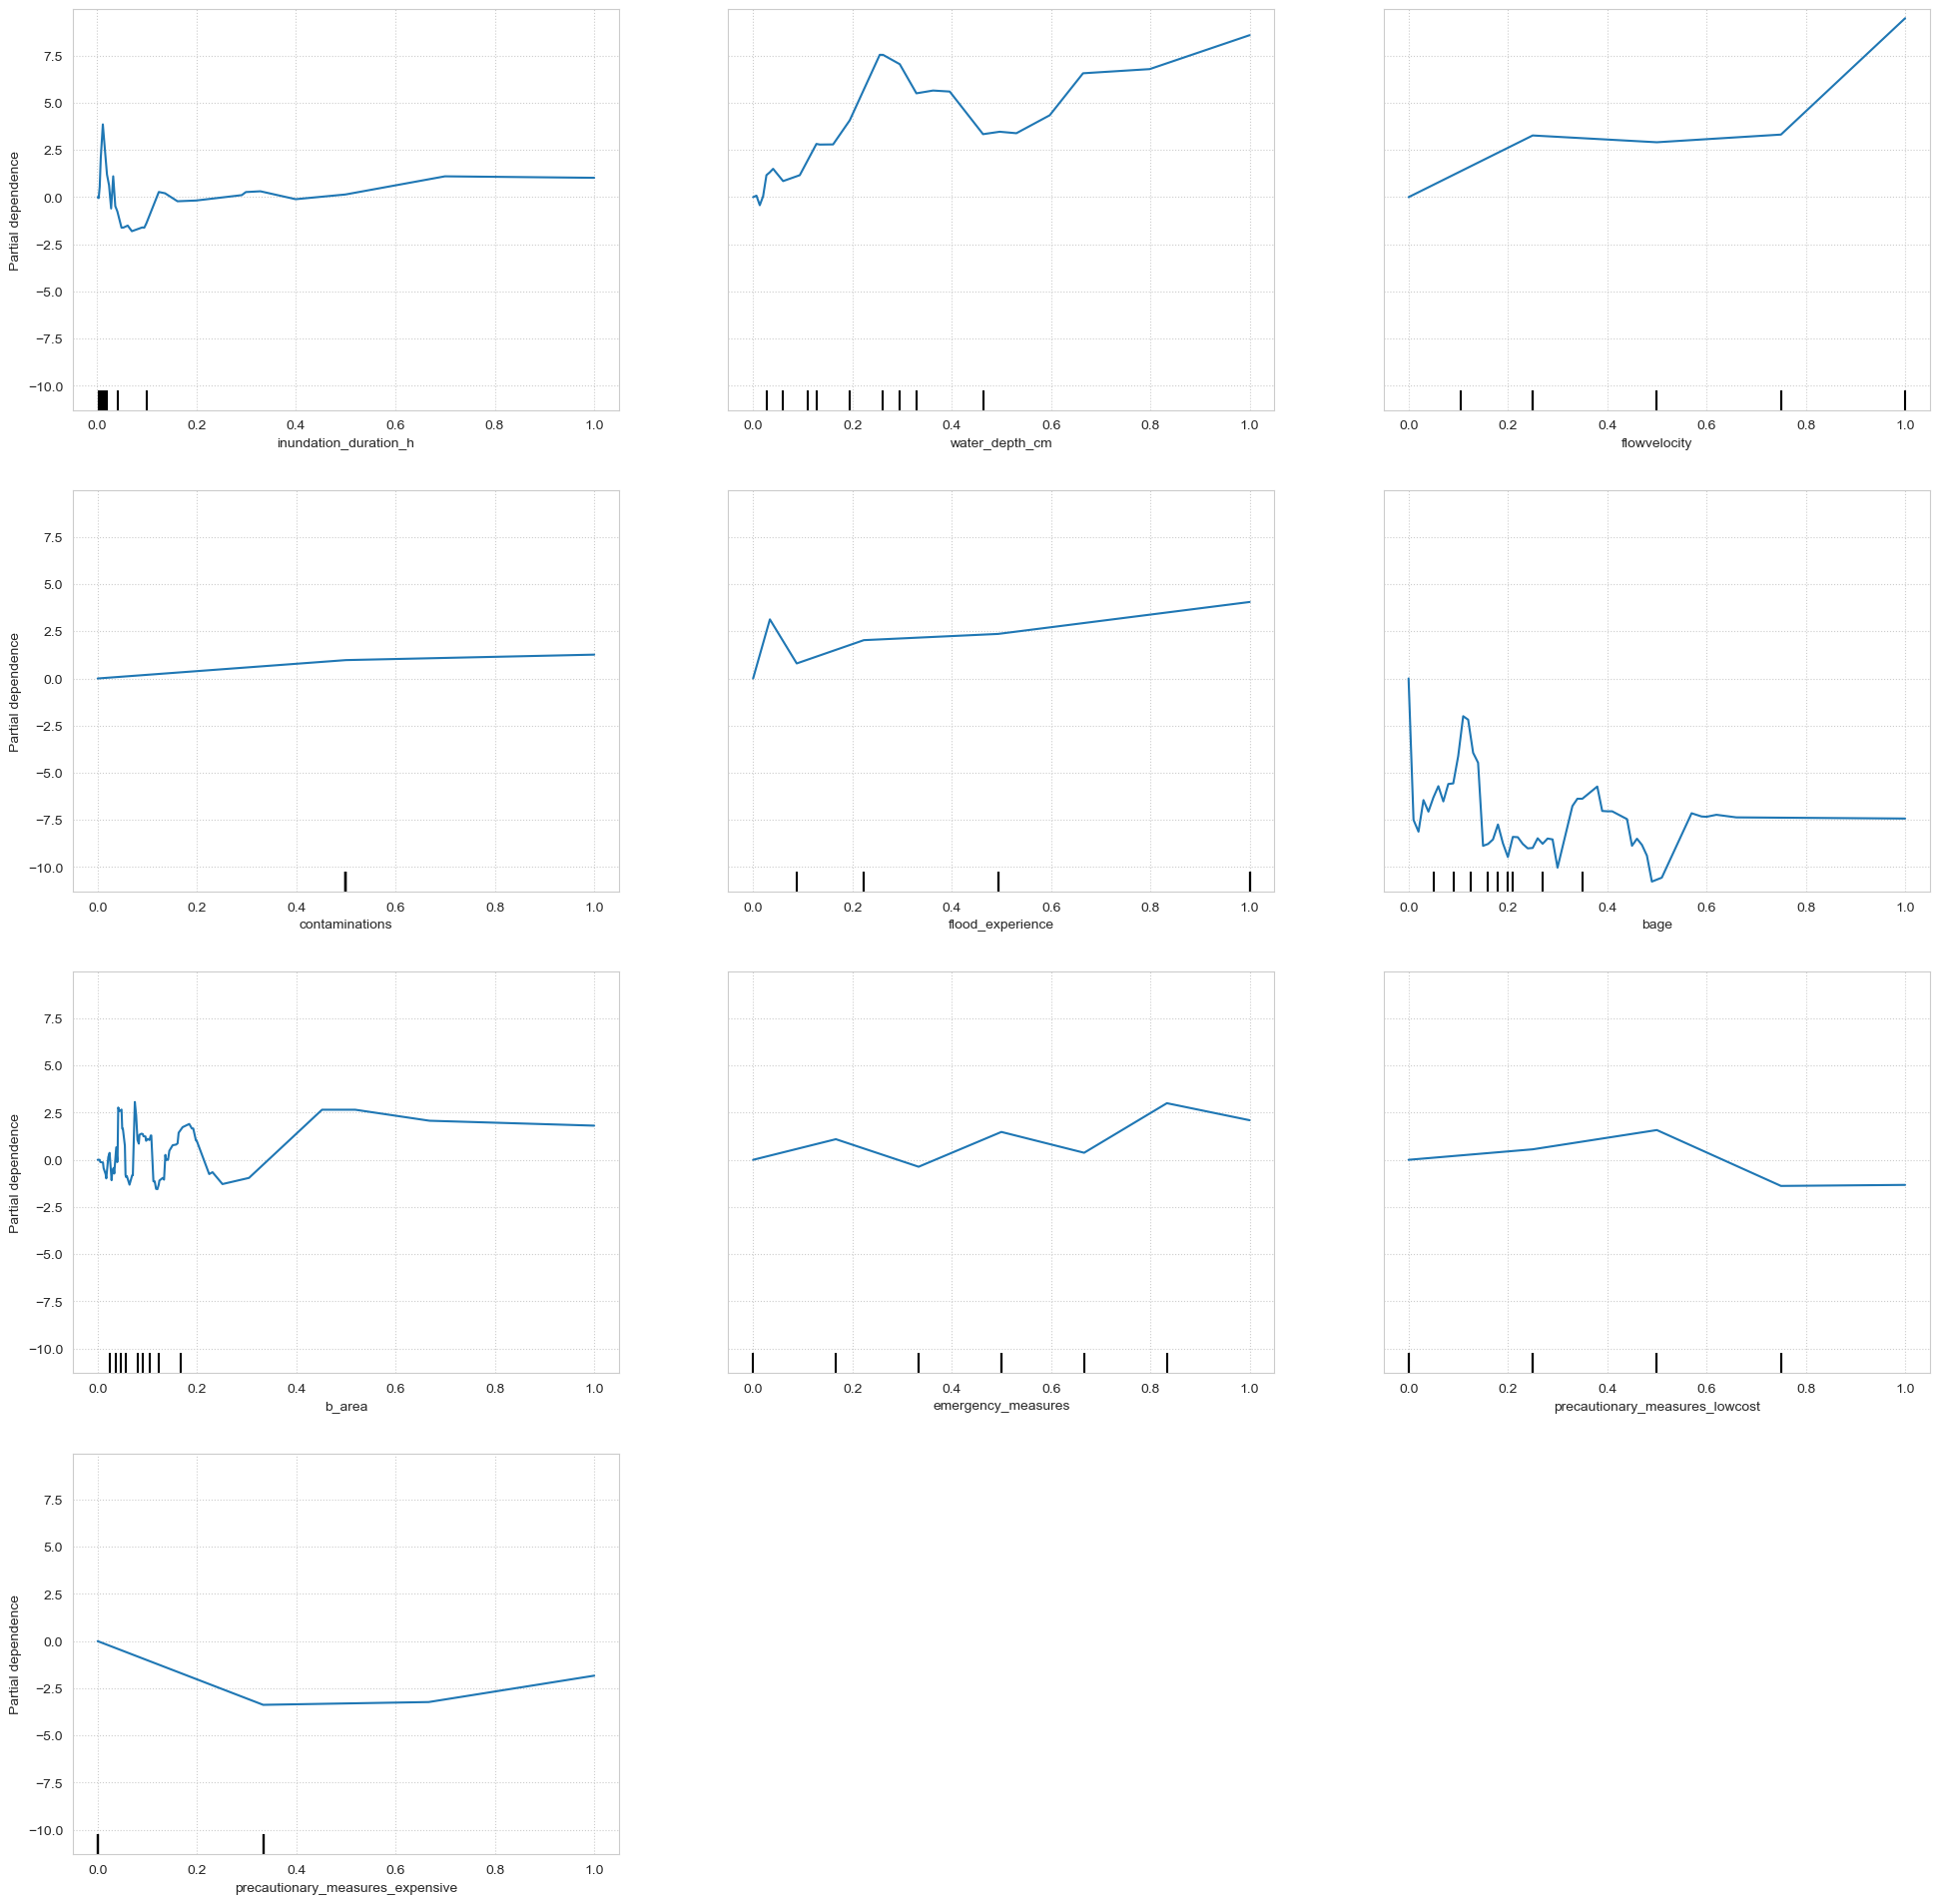

In [24]:
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.inspection import PartialDependenceDisplay

y_name=target
model_name = "XGBRegressor"
feature_name = "inundation_duration_h"
X = Xy_pdp.dropna().drop(y_name, axis=1)

# # scale feature distributions in pd plots across models
# if scale:
#     X =  pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

# pdp_features[model_name]#[feature]  
partial_dep = partial_dependence(   
    final_models_trained[model_name], 
    X=X, features=feature_name, 
    #grid_resolution=X.shape[0], 
    kind='both', # ICE plot and PDP
    #percentiles=(0.05, .95),
    # percentiles=percentile_range,
)

print(X.columns)

fig, ax = plt.subplots(figsize=(24, 24))
fig_pdp = PartialDependenceDisplay.from_estimator(
    final_models_trained[model_name], X, [0, 1, 2,3,4,5,6,7,8,9], 
    kind='average', centered=True, ax=ax)
fig_pdp
# fig.get_figure().savefig( f'../../figures/ice_plots{target}_{model_name}.png', dpi=300, bbox_inches="tight")
# plt.close()



'Target_businessreduction'

12-08-2023 01:07:54 - __feature_extraction_bred__ - INFO - Creating boxplots for range of performane scores from outer folds of nested cross-validation


12-08-2023 01:08:12 - __feature_extraction_bred__ - INFO - Outer evaluation scores of nested cross-validation (median) :
        ElasticNet_score  ElasticNet_score_std  XGBRegressor_score   
MAE              18.198                 1.744              14.995  \
RMSE             23.560                 3.835              22.414   
MBE               0.086                 4.702               3.655   
SMAPE            62.460                 7.245              61.309   

       XGBRegressor_score_std  cforest_score  cforest_score_std  
MAE                     1.483         16.230              1.665  
RMSE                    2.274         21.860              2.404  
MBE                     2.917         -0.049              1.929  
SMAPE                   5.769         60.005              4.351   
.. saved to ../../model_results/models_evaluation/degree_of_loss/performance_Target_businessreduction.xlsx
12-08-2023 01:08:12 - __feature_selection__ - INFO - Normalize columns to scale: 0 - 10
12-08-


ElasticNet predicted target from cross-valdiated outer folds:
           nobs  median       mean   min max  variance
empirical   321    10.0  17.199377  [0, 100]    570.70
predicted   321    17.0  16.651090   [7, 27]      7.75

cforest predicted target from cross-valdiated outer folds:
           nobs  median       mean   min max  variance
empirical   321    10.0  17.199377  [0, 100]    570.70
predicted   321    16.0  16.741433   [5, 39]     50.77

XGBRegressor predicted target from cross-valdiated outer folds:
           nobs  median       mean   min max  variance
empirical   353    10.0  17.807365  [0, 100]    598.35
predicted   353    12.0  14.124646  [-2, 64]    114.97


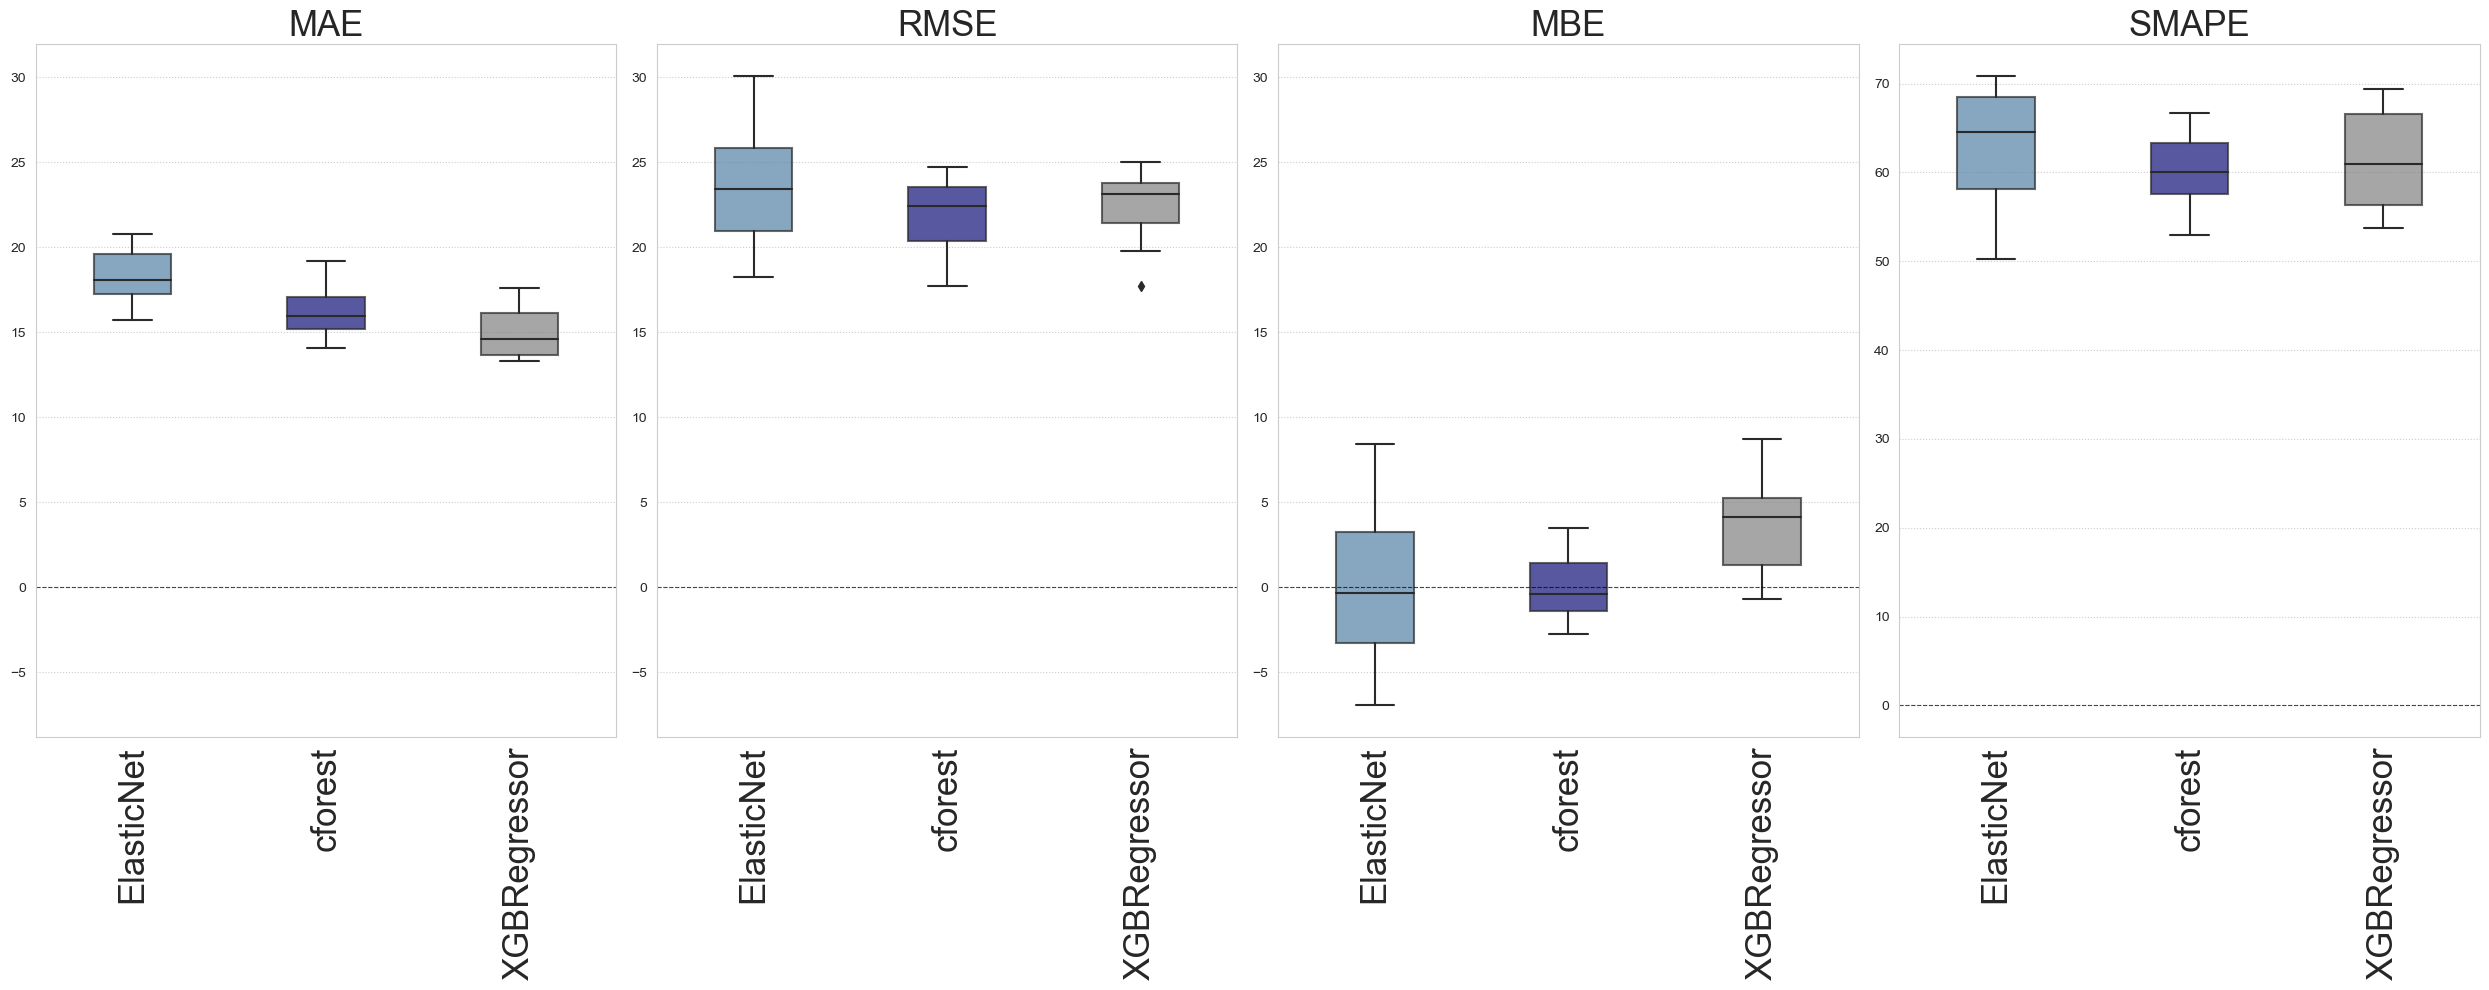

In [6]:

## Plot performance ranges of all evaluated estimators from outer cross-validation 
logger.info("Creating boxplots for range of performane scores from outer folds of nested cross-validation")
boxplot_outer_scores_ncv(
    models_scores,
    outfile=f"../../model_results/models_evaluation/degree_of_loss/boxplot_scores4ncv_{target}.png")

# store avergaed scores and std for later usage
## TODO remove overhead  -> store avergaed scores and std during loop
xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
xgb_model_evaluation_std = pd.DataFrame(models_scores["XGBRegressor"]).std(axis=0)   # get respective standard deviations
crf__model_evaluation = pd.DataFrame(models_scores["cforest"]).mean(axis=0)
crf_model_evaluation_std = pd.DataFrame(models_scores["cforest"]).std(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).mean(axis=0)
en_model_evaluation_std = pd.DataFrame(models_scores["ElasticNet"]).std(axis=0)
# xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).median(axis=0)  # get median of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
# xgb_model_evaluation_std = pd.DataFrame(models_scores["XGBRegressor"]).std(axis=0)   # get respective standard deviations
# crf__model_evaluation = pd.DataFrame(models_scores["cforest"]).median(axis=0)
# crf_model_evaluation_std = pd.DataFrame(models_scores["cforest"]).std(axis=0)
# en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).median(axis=0)
# en_model_evaluation_std = pd.DataFrame(models_scores["ElasticNet"]).std(axis=0)

model_evaluation = pd.concat([en_model_evaluation, en_model_evaluation_std, xgb_model_evaluation, xgb_model_evaluation_std, crf__model_evaluation, crf_model_evaluation_std], axis=1)
model_evaluation.columns = ["ElasticNet_score", "ElasticNet_score_std", "XGBRegressor_score", "XGBRegressor_score_std", "cforest_score", "cforest_score_std"]

## rename metrics
model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"../../model_results/models_evaluation/degree_of_loss/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
# logger.info(f"Outer evaluation scores of nested cross-validation (mean) :\n {model_evaluation.round(3)} \n.. saved to {outfile}")
logger.info(f"Outer evaluation scores of nested cross-validation (median) :\n {model_evaluation.round(3)} \n.. saved to {outfile}")




## Feature Importances 

#### prepare Feature Importances 
## Have the same feature importance method across all applied ML models
## Weight Importances by model performance on outer loop (mean MAE)
## **Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)**

## weight FI scores based on performance ; weigth importances from better performed models stronger
model_weights =  {
    "XGBRegressor_importances" : np.mean(models_scores["XGBRegressor"]["test_MAE"]),
    "ElasticNet_importances" : np.mean(models_scores["ElasticNet"]["test_MAE"]),
    "cforest_importances" : np.mean(models_scores["cforest"]["test_MAE"]),
}
df_feature_importances_w = fs.calc_weighted_sum_feature_importances(df_feature_importances, model_weights)


####  Plot Feature importances

## the best model has the highest weighted feature importance value
df_feature_importances_plot = df_feature_importances_w

## drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot.weighted_sum_importances > 0.0, : ] 

## plot stacked FI
f.plot_stacked_feature_importances(
    df_feature_importances_plot[["cforest_importances_weighted", "ElasticNet_importances_weighted", "XGBRegressor_importances_weighted",]],
    target_name=target,
    model_names_plot = ("Conditional Random Forest", "Elastic Net", "XGBRegressor"),
    outfile=f"../../model_results/models_evaluation/degree_of_loss/feature_importances_{target}.png"
)


## Save final feature space 
### The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
logger.info(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
logger.info(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_w["weighted_sum_importances"].sort_values(ascending=False).index##[:10]

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates.drop(target, axis=1), # TODO adpat function that target is only once added
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../model_results/selected_features/degree_of_loss/final_predictors_{target}.xlsx"
)



## Partial dependence

## PDP shows the marginal effect that one or two features have on the predicted outcome.

## store partial dependences for each model
pdp_features = {a : {} for a in ["ElasticNet", "XGBRegressor", "cforest"]}

for model_name in ["cforest", "ElasticNet", "XGBRegressor"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]

    ## NOTE scaling mandatory for cforest model (which dont accepts the rescaled values for R PDPs function)
    ## also to have all models in the same plot scaling of the predictors is needed.
    # For EN and cforest incomplete cases are removed, therefore the fitting has to be done on the entire dataset (as used for XGB)
    scaler = MinMaxScaler()
    scaler.fit(df_candidates.drop([target, "geometry"], axis=1))  # needed due that Elastic Net has no incomplete records but needs same nomrlaization as XGB
    X_pdp = pd.DataFrame(
        scaler.transform(X_pdp), # for same x-axis scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            # "percentiles" : (0.05, .95), # causes NAN for some variables for XGB if (0, 1)
            "scale"  : True
        }  
        # get Partial dependences for sklearn models      
        if model_name != "cforest": 
            partial_dep = me.get_partial_dependence(**features_info)
        # get Partial dependences for R models      
        else:  
            #  change function only temporary to process R model instead of sklearn models
            # features_info.pop("percentiles")
            partial_dep = me.decorator_func(**features_info) (me.get_partial_dependence)()  

        pdp_features[model_name][predictor_name] = partial_dep



## Plot PDP

most_important_features = df_feature_importances_plot.sort_values("weighted_sum_importances", ascending=False).index
categorical = [] # ["flowvelocity", "further_variables .."]
ncols = 3
nrows = len(most_important_features[:9])
idx = 0

plt.figure(figsize=(10,25))
# plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)

## create PDP for all three models
for feature in most_important_features[:9]:
    for model_name, color, idx_col in zip(["cforest", "ElasticNet", "XGBRegressor"], ["darkblue", "steelblue","grey"], [0, 0, 0]):

        # idx position of subplot and plot settings
        sns.set_style("whitegrid", {'grid.linestyle': ':'})
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        ## partial dependence of one feature for one model to plot
        df_pd_feature = pdp_features[model_name][feature]  
        
        # plot
        p = f.plot_partial_dependence(
            df_pd_feature, 
            feature_name=feature, 
            partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../../model_results/models_evaluation/degree_of_loss/pdp_{target}.png",
            **feature_info
            )
        p
        # sns.rugplot(pdp_features[model_name][feature], x=feature,  y="yhat", height=-.05)
        #targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
        #if target == "Target_relative_contentloss_euro":
        plt.ylim(0,30)

        visible_ticks = {"top": False, "right": False}
        plt.tick_params(axis="x", which="both", **visible_ticks)
        
    sns.rugplot(df_pd_feature, x=feature, height=.02, color="black")
    idx = idx + 1




### Empirical ~ predicted
## use y_pred cross-valdiated from outer folds, mulitplied by 100 for more readable output
for k,v in predicted_values.items():
    print(f"\n{k} predicted target from cross-valdiated outer folds:")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# ### Plot prediction error 
f.plot_residuals(
    residuals=predicted_values, 
    model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
    model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
    outfile=f"../../model_results/models_evaluation/degree_of_loss/residuals_{target}.png"
)



In [2]:
for metric in models_scores[model_name].keys():
    print(metric)
    print(metric, models_scores[model_name][metric])

test_MAE
test_MAE [16.606018318108983, 15.761476635192082, 17.79613417361915, 19.139009540817273, 19.744847729162952, 18.319427306258852, 20.120177968064453, 20.106244398359216, 17.410291671471157, 15.711078263298301]
test_RMSE
test_RMSE [21.302844593792134, 19.108971419175834, 24.580207846751446, 24.222320614394075, 28.0601018779343, 22.594735763652594, 26.27367426702812, 29.677508950713598, 20.66361606140396, 18.23824629558272]
test_MBE
test_MBE [-6.434324890327934, -1.652398165302614, 3.976326431729604, 0.011296495898496572, 8.412160197457977, -0.7301764933061752, 0.9997705592786305, 4.826873154663357, -3.82348312362993, -4.4493752208283155]
test_SMAPE
test_SMAPE [70.28325053254345, 57.944145530402125, 52.38428845880723, 68.86296201341173, 50.30060956497388, 68.92410256188231, 64.79170049340892, 57.46145599465973, 67.4453230153451, 64.43258669931802]


In [25]:
### Empirical median ~ predicted median
## use y_pred cross-valdiated from outer folds
for k,v in predicted_values.items():
    print(f"\n{k} predicted target from cross-valdiated outer folds:")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))



ElasticNet predicted target from cross-valdiated outer folds:
           nobs  median       mean   min max  variance
empirical   274    10.0  18.419708  [0, 100]    599.78
predicted   274    18.0  18.076642   [4, 32]     32.65

cforest predicted target from cross-valdiated outer folds:
           nobs  median       mean   min max  variance
empirical   274    10.0  18.419708  [0, 100]    599.78
predicted   274    17.0  18.047445   [6, 39]     48.27

XGBRegressor predicted target from cross-valdiated outer folds:
           nobs  median       mean   min max  variance
empirical   353    10.0  17.807365  [0, 100]    598.35
predicted   353    14.0  15.770538  [-7, 80]    147.75


In [13]:
### Partial dependence
## PDP shows the marginal effect that one or two features have on the predicted outcome.

## store partial dependences for each model
pdp_features = {a : {} for a in ["ElasticNet", "XGBRegressor", "cforest"]}

for model_name in ["cforest", "ElasticNet", "XGBRegressor"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "percentiles" : (.05, .95), # causes NAN for some variables for XGB if (0, 1)
            "scale"  : True
        }  
        # get Partial dependences for sklearn models      
        if model_name != "cforest": 
            partial_dep = me.get_partial_dependence(**features_info)
        # get Partial dependences for R models      
        else:  
            #  change function only temporary to process R model instead of sklearn models
            features_info.pop('percentiles')  # R package has no percentiles to set
            partial_dep = me.decorator_func(**features_info) (me.get_partial_dependence)()  

        pdp_features[model_name][predictor_name] = partial_dep






# ## visual check if hyperparameter ranges are good or need to be adapted
# for i in range(len(model_evaluation_results["estimator"])):
#     print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 50, 'model__max_depth': 15, 'model__learning_rate': 0.3, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}
XGBRegressor:  {'model__seed': 42, 'model__n_estimators': 30, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'mode

In [14]:
model_evaluation_results.keys()
# ## visual check if hyperparameter ranges are good or need to be adapted
# for i in range(len(model_evaluation_results["estimator"])):
#     print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


dict_keys(['fit_time', 'score_time', 'estimator', 'test_MAE', 'test_RMSE', 'test_MBE', 'test_R2', 'test_SMAPE'])

## Evaluation
Evaluate models based on performance on outer cross-validation 

In [ ]:
## get std of CRF from inner folds
l = []
for idx in range(1,10):  # number of estimators in outer folds
    
    df = me.r_models_cv_predictions(models_trained["cforest"], idx)

    mae = mean_absolute_error(df.testy, df.predy)
    rmse =  np.sqrt( np.mean((df.testy - df.predy)**2) ) #(df.testy, df.predy)
    mbe = e.mean_bias_error(df.testy, df.predy)
    r2 = mean_absolute_error(df.testy, df.predy)
    smape = e.symmetric_mean_absolute_percentage_error(df.testy, df.predy)
    l.append([mae, rmse, mbe, r2, smape ])


In [ ]:
print("CRF: mean of evaluation scores and their standard deviation across tested models in inner cv:",
        f"\nmae_mean, mae_std: {np.mean([score[0] for score in l]), np.std([score[0] for score in l]) } ",
        f"\nrmse_mean, rmse_std: {np.mean([score[1] for score in l]), np.std([score[1] for score in l]) } ",
        f"\nmbe_mean, mbe_std: {np.mean([score[2] for score in l]), np.std([score[2] for score in l]) } ",
        f"\nr2_mean, r2_std: {np.mean([score[3] for score in l]), np.std([score[3] for score in l]) } ",
        f"\nsmape_mean, smape_std: {np.mean([score[4] for score in l]), np.std([score[4] for score in l]) } ",
)

print("\nElastic Net: mean of evaluation scores and their standard deviation across tested models in inner cv:",
    pd.concat([
            pd.DataFrame(models_scores["ElasticNet"]).drop("estimator",axis=1).mean(axis=0),
            pd.Series(pd.DataFrame(models_scores["ElasticNet"]).drop("estimator",axis=1).std(axis=0))
        ], axis=1
    )
      )

print("\nXGB: mean of evaluation scores and their standard deviation across tested models in inner cv:",
    pd.concat([
            pd.DataFrame(models_scores["XGBRegressor"]).drop("estimator",axis=1).mean(axis=0),
            pd.Series(pd.DataFrame(models_scores["XGBRegressor"]).drop("estimator",axis=1).std(axis=0))
        ], axis=1
    )
    )

# EN
# test_neg_MAE    -0.062560  0.019390
# test_neg_RMSE   -0.113259  0.069073
# test_MBE        -0.000050  0.032531
# test_R2         -0.432757  1.121662
# test_SMAPE    -127.259363  9.495025

# XGB: mean of evaluation scores and their standard deviation across tested models in inner cv:                         0          1
# fit_time        21.798437   0.712181
# score_time       0.012409   0.002156
# test_neg_MAE    -0.067284   0.018891
# test_neg_RMSE   -0.142585   0.061684


## best model for BRed : XGB test_MAE    -16.769906    2.025747  (no subsampling of feautres)
## best model for BRed : XGB test_MAE    -16.007160    1.684777  (with subsampling of feautres) 


In [ ]:
xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).drop("estimator",axis=1).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
#crf_model_evaluation = pd.DataFrame(models_scores["cforest"]).mean(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).drop("estimator",axis=1).mean(axis=0)

# Applying xgb on Target_relative_contentloss_euro:
# outer CV: MAE: -0.095 (0.032)


## TODO add/derive MBE, MAPE of CRF
crf_model_evaluation = pd.DataFrame({
    "cforest": [None, 
            None,
            round(np.mean([score[0] for score in l]), 3), # MAE
            round(np.mean([score[1] for score in l]), 3),  # RMSE
            round(np.mean([score[2] for score in l]), 3), # MBE 
            round(np.mean([score[3] for score in l]), 3),  # R2
            round(np.mean([score[4] for score in l]), 3), # SMAPE 
            ]

    }, index=xgb_model_evaluation.index
)

model_evaluation = pd.concat([en_model_evaluation, xgb_model_evaluation, crf_model_evaluation], axis=1)
model_evaluation.columns = ["ElasticNet", "XGBRegressor", "cforest"]
model_evaluation.index = model_evaluation.index.str.replace("neg_", "")
model_evaluation.loc["test_MAE"] = model_evaluation.loc["test_MAE"].abs()
model_evaluation.loc["test_RMSE"] = model_evaluation.loc["test_RMSE"].abs()


model_evaluation.round(3)

### Coefficients of Elastic Net

EN: The coefficients of elastic net regression represent the linear relationship between the features and the target variable, adjusted by the regularization terms. The larger the absolute value of a coefficient, the stronger the effect of the corresponding feature on the target variable. The sign of a coefficient indicates the direction of the effect. 

**Note: The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
#.reset_index(drop=True).set_index(list(X.columns).insert(0, "intercept"))

models_coef#["en_selfbuilt"].sort_values("Probabilities")


#### Coefficient variability

High variabaility indicates possible strong collinearity with other features

Coefficient of ML models are generally unable to infer causal effects.
It might be tempting to look at the coefficient of education on wage from our last model (or any model for that matter) and conclude that it captures the true effect of a change in the standardized education variable on wages.
Unfortunately there are likely **unobserved confounding variables** that either inflate or deflate that coefficient. A confounding variable is a variable that causes both EDUCATION and WAGE.

In [ ]:
cv_en_model = models_scores["ElasticNet"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])

In [ ]:
cv_en_model = models_scores["ElasticNet"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])
coefs = pd.DataFrame(
    # [est[-1].best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]]
    [est.best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]], columns=X.columns
)


In [ ]:
#coefs.mean(axis=0)

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="steelblue", saturation=0.7, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability of Elastic Enet")
plt.subplots_adjust(left=0.3)



--> coefficients of flowvelocity and purchase pumping equipment varying a lot depneding of the fold
--> registered capital, average monthly sale, monthly income coefficients are varying a lot depending of the fold.

**The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

### Feature Importances 


#### prepare Feature Importances 
Have the same feature importance method across all applied ML models
Weight Importances by model performance on outer loop (mean MAE)

In [ ]:
s = df_feature_importances

In [ ]:
## Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)

## scale importance scores to  same units (non important feautres were removed before)
df_feature_importances = pd.DataFrame(
    MinMaxScaler(feature_range=(0,10)).fit_transform(df_feature_importances), 
    index=df_feature_importances.index,
    columns=df_feature_importances.columns
)
print(df_feature_importances.head(2))


In [ ]:
## weight FI scores based on performance 
## weigth importances from better performed models more

crf_scores = models_scores[f"cforest"] ["MAE"] # outer MAE of CRF

for m in ["XGBRegressor", "ElasticNet"]: 
    df_feature_importances[f"{m}_importances_weighted"] =  df_feature_importances[f"{m}_importances"] / np.abs(models_scores[m]["test_MAE"].mean())
df_feature_importances["cforest_importances_weighted"]  = df_feature_importances["cforest_importances"] / crf_scores    # weigth better models more

df_feature_importances.head(2)


In [ ]:
## overall FI scores
df_feature_importances["mean_all_importances_weighted"] = df_feature_importances[["XGBRegressor_importances_weighted","ElasticNet_importances_weighted", "cforest_importances_weighted"]].mean(axis=1)
## drop feautres which are unimportant
df_feature_importances = df_feature_importances.loc[df_feature_importances["mean_all_importances_weighted"] > 0.000000, : ]
print(
    "10 most important features across all models (weighted on mean MAE scores):\n" ,
    #df_feature_importances.overall_importances.sort_values(ascending=False).head()
)
df_feature_importances.sort_values("mean_all_importances_weighted", ascending=False)[:10]#.describe()


In [ ]:
## save to disk
df_feature_importances.to_excel(
    f"../../input_survey_data/selected_predictors/feature_importances_allmodels_{target.split('_')[1]}.xlsx", 
    index=False
)


####  Plot Feature importances

In [ ]:
## the best model has the highest weighted feature importance value
# df_feature_importances.describe()

In [ ]:
#df_feature_importances = df_feature_importances_logreg
df_feature_importances["sum_all_importances_weighted"] = df_feature_importances.fillna(0)["XGBRegressor_importances_weighted"] + df_feature_importances.fillna(0)["ElasticNet_importances_weighted"] + df_feature_importances.fillna(0)["cforest_importances_weighted"]
df_feature_importances = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=True)
df_feature_importances.head(5)

In [ ]:
df_feature_importances

In [ ]:
### drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances#.loc[df_feature_importances.sum_all_importances_weighted > 0.01, : ] 
#df_feature_importances_plot = df_feature_importances.loc[df_feature_importances.sum_all_importances_weighted > 2, : ] 
#df_feature_importances_plot = df_feature_importances.sort_values("mean_all_importances_weighted", ascending=True)

plt.figure(figsize=(30, 22))
#df_feature_importances.plot.barh(
df_feature_importances_plot[["cforest_importances_weighted", "ElasticNet_importances_weighted", "XGBRegressor_importances_weighted",]].plot.barh(
    stacked=True, 
    #color="darkblue",
    color={"cforest_importances_weighted":"darkblue", "ElasticNet_importances_weighted":"steelblue", "XGBRegressor_importances_weighted":"grey"},
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="Conditional Random Forest")
middle_bar = mpatches.Patch(color="steelblue", label="Elastic Net")
bottom_bar = mpatches.Patch(color="grey", label="XGBoost")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(handles=[top_bar, middle_bar, bottom_bar], loc="lower right")
#plt.tight_layout()
#plt.grid(None)

plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./model_results/models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



### Save final feature space 
The final selection of features is used later for the non-parametric Bayesian Network

In [ ]:
## sort features by their overall importance (weighted sum across across all features) , first column contains the target
final_feature_names = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=False).index##[:10]

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")

fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../input_survey_data/final_data_{target.split('_',1)[-1].rsplit('_',1)[0]}_tueb.xlsx"
)


### Partial dependence
PDP shows the marginal effect that one or two features have on the predicted outcome. It shows whether the relationship between the target and a feature is linear, monotonic, or more complex ,as well as the direction of the relationship (see also Coefficients for linear regression tasks). It is introduced by J. H. Friedman and has been widely applied in machine learning modeling.

In [ ]:
# # fit_params={"model__early_stopping_rounds":10, 
# #             "model__eval_metric" : "mae", 
# #             "model__eval_test_size": 50,
# #             }
# tst_final_model = RandomizedSearchCV( # GridSearchCV( 
#             estimator=pipe,
#             #param_grid=param_space,
#             param_distributions=param_space,
#             cv=cv, 
#             scoring="neg_mean_absolute_error",
#             refit=True,   
#             random_state=seed,
#         )

# df_candidates_t_nonan = df_Xy.dropna()
# tst_final_model.fit(
#     df_candidates_t_nonan.drop(target, axis=1), 
#     df_candidates_t_nonan[target],
#     #**fit_params
# )
# final_models_trained["xgb_tst"] = tst_final_model.best_estimator_

In [ ]:
# ## TODO test with percenticels without nans


In [ ]:
# m = model_evaluation()
# t = m.decorator_func(model=final_models_trained["cforest"], Xy=eval_sets["cforest"], y_name=target, feature_name="flowvelocity", scale=True) (get_partial_dependence)() #model=final_models_trained["cforest"], Xy=eval_set_list["ElasticNet"]["ElasticNet"], y_name=target, feature_name="flowvelocity", scale=False)
# t
## Q:
## how to simplyfy call of decorated function-> eg. second part of argumets for get_partial_dependence() is useless
## why call fun(*, **) inside wrapper(), or purpoe of @decorator(func)
## how to store multiple decorators: in the classes in which they decorate a func or in a seperate class eg. for only R-decorators

In [ ]:
## EN, XGB get partial dependences

## store partial dependences for each model
pdp_features = {a : {} for a in ["ElasticNet", "XGBRegressor", "cforest"]}

ee = model_evaluation()


for model_name in ["ElasticNet", "cforest", "XGBRegressor"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)


    for predictor_name in X.columns.to_list(): 
        features_info =  {
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "percentiles" : (0.05, .95), # causes NAN for some variables for XGB if (0, 1)
            "scale"  : True
        }         
        if model_name != "cforest":   # process sklearn models
            partial_dep = me.get_partial_dependence(**features_info)

        else:  # process R models
            features_info.pop('percentiles')  # R package has no percentiles to set
            partial_dep = me.decorator_func(**features_info) (ee.get_partial_dependence)()  #  change function only temporary to process R model instead of sklearn models

        pdp_features[model_name][predictor_name] = partial_dep



In [ ]:
pdp_features["XGBRegressor"]

In [ ]:
plt.figure(figsize=(10,25))
#plt.subplots_adjust(hspace=0.9)
#plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


most_important_features = df_feature_importances_plot.sort_values("sum_all_importances_weighted", ascending=False).index



idx = 0
categorical = [] # ["flowvelocity"]
ncols = 3
nrows = len(most_important_features[:9])

## create PDP for all three models
for feature in most_important_features[:9]:
    for model_name, color, idx_col in zip(["cforest", "ElasticNet", "XGBRegressor"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, feature_name=feature, partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../../model_results/models_evaluation/degree_of_loss/pdp_{target}.png",
            **feature_info
            )
        p
        sns.rugplot(df_pd_feature, x=feature, y="yhat", heiht=-.02)
        plt.ylim(10,30)
        
    idx = idx + 3

#plt.subplots_adjust(top=0.2)
#plt.savefig("test_pdp.png", bbox_inches="tight")


- for large buidlings the en model predicts higher losses
- higher losses are also linked in the model with slightly less flood experience and higher flowvelocity ,
- model predicts for shops with very low registered capital less losses
- implmenting resistant building material after the flood (nb=4) is linked in the model with higher losses

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean /variance / std  compared to empirical distribution

In [ ]:
#model.predict()


In [ ]:
print("Testing models for : ", target)
em.empirical_vs_predicted(
    X, y,
    models_list = [models_trained["cforest"], models_trained["XGBRegressor"]]#, models_trained["trained_en"]] 
    #models_trained#[f"trained_{model_name}_cv"]
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO fix y empirical
# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


In [ ]:
# print(target)
# print(X.shape)

# df_importance

In [ ]:
print("median entire ds")
print(np.median(y))
#print(np.median(model.predict(X)))
y_pred = model
print(np.median([outer_y_pred[{model_name}]]))

print("mean entire ds")
print(np.mean(y))
#print(np.mean(model.predict(X)))
y_pred = model
print(np.mean([outer_y_pred[{model_name}]]))


In [ ]:
##  MAE: + in target unit +  less likely to be affected by extreme values.
## MAPE: r (MAPE) quantifies the average absolute difference between 
## the anticipated and observed values of the target variable as a percentage of the observed value. 
## The method works well for assessing models where the target variable spans a broad range of scales


In [ ]:


##pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#
pipe_name = pipelines[0]

#model_eval = pickle.load(open(f"./models_trained/best_elasticnet_{target}_{pipe_name}.sav", 'rb'))
#elastic_net_eval.get_params()



### Plot prediction error 

In [ ]:
f.plot_residuals(residuals=predicted_values, model_names_abbreviation=["ElasticNet", "XGBRegressor", "cforest"],  model_names_plot=["Elastic Net", "XGBoost", "Conditional Random Forest"])
